# Calculate model simulation difference & observation uncertainty

## Base model difference on flow categories determined by observation percentiles

In [1]:
import string
import cartopy
import cartopy.crs as ccrs
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from scipy import stats
from pathlib import Path
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Set Paths and Config


In [2]:
# Set Paths
ROOT = Path("/gpfs/work1/0/wtrcycle/users/jaerts/camels_uk/")
AUXDATA = Path(f"{ROOT}/aux_data")
RESULTS = Path(f"{ROOT}/results/")
OBSDIR = Path(f"{AUXDATA}/CAMELS-GB/data/timeseries/")

# Set Config
basins_shp = f"{AUXDATA}/CAMELS-GB/data/CAMELS_GB_catchment_boundaries/CAMELS_GB_catchment_boundaries.shp"
uncertainty_file = f"{AUXDATA}/CAMELS-GB/data/CAMELS_GB_hydrometry_attributes.csv"

# load uncertainty file and drop nan
df_uncertainty = pd.read_csv(uncertainty_file, index_col='gauge_id')

df_uncertainty = df_uncertainty[df_uncertainty['q5_uncert_upper'].notna()]
df_uncertainty = df_uncertainty[df_uncertainty['q5_uncert_lower'].notna()]
df_uncertainty = df_uncertainty[df_uncertainty['q95_uncert_upper'].notna()]
df_uncertainty = df_uncertainty[df_uncertainty['q95_uncert_lower'].notna()]

# Get available basin IDs wflow_sbm
df_wflow = pd.read_csv("/gpfs/work1/0/wtrcycle/users/jaerts/camels_uk/results/wflow_sbm/evaluation_overview_wflow.csv", index_col='basin_id')
df_basin = df_wflow.join(df_uncertainty, how='right')
df_basin = df_basin[df_basin['kge_np'].notna()]

basin_ids = df_basin.index.to_list()

# Time period (drop first year)
start_date = '2008-10-01'
end_date   = '2015-09-30'

In [5]:
df_uncertainty = df_uncertainty.reset_index()
df_uncertainty

In [8]:
df_uncertainty = df_uncertainty[['gauge_id']]
df_uncertainty = df_uncertainty.rename(columns={'gauge_id':'basin_id'})

In [10]:
df_uncertainty.to_csv(f"{ROOT}/aux_data/available_basin_ids_uncertainty.csv")

# Calculate observation percentiles

In [3]:
# Set flow categories based on percentiles
flow_categories = {'low_flow': (5, 25),
                   'mean_flow': (25, 75),
                   'high_flow': (75, 95)}

In [4]:
for basin_id in basin_ids:
    # print(basin_id)
    
    # Get wflow_sbm simulation timeseries # CHANGE!!!
    df_wflow = pd.read_csv(f"{ROOT}/results/wflow_sbm/evaluation/{basin_id}_evaluation_simulations.csv", index_col='time') 
    df_wflow = df_wflow.rename(columns={'evaluation':'wflow'})
    
    # Get pcr-globwb simulation timeseries
    df_pcrglob = pd.read_csv(f"{ROOT}/results/pcr-globwb/evaluation/{basin_id}_evaluation_simulations_adjusted_location_4px.csv", index_col='time')
    df_pcrglob = df_pcrglob.rename(columns={'sim':'pcrglob'})
    df_pcrglob = df_pcrglob.groupby('time').mean()
    
    # Combine to simulation dataframe
    df_sim = df_wflow.join(df_pcrglob)
    
    # Calculate absolute difference
    df_sim['model_diff'] = np.abs(df_sim['wflow']-df_sim['pcrglob'])
    
    # Get obervation timeseries
    df_obs = pd.read_csv(f'{OBSDIR}/CAMELS_GB_hydromet_timeseries_{basin_id}_19701001-20150930.csv',
                        index_col='date')
    
    # Select evaluation period
    mask = (df_obs.index >= start_date) & (df_obs.index <= end_date)
    df_obs = df_obs.loc[mask]
    
    # Drop NaN values
    df_obs = df_obs[df_obs['discharge_vol'].notna()]
    
    # For each flow category calculate:
    # 1. observation percentiles
    # 2. absolute model difference
    # 3. average streamflow uncertainty percentage
    # 4. streamflow uncertainty values
    
    for category in flow_categories:
        
        df_out = pd.DataFrame()

        # Calculate percentiles
        lower = flow_categories[category][0]
        upper = flow_categories[category][1]
        
        obs_perc_lower = np.percentile(df_obs.discharge_vol,lower,axis=0)
        obs_perc_upper = np.percentile(df_obs.discharge_vol,upper,axis=0)
        
        # Select obs based on percentiles
        mask = (df_obs.discharge_vol >= obs_perc_lower) & (df_obs.discharge_vol <= obs_perc_upper)
        df_obs_selected = df_obs.loc[mask]
               
        # Join model difference based on obs percentiles
        df_joined = df_obs_selected.join(df_sim)
        
        # Average upper and lower streamflow uncertainties per category
        df_uncertainty = pd.read_csv(uncertainty_file, index_col='gauge_id').loc[int(basin_id)]
        
        # In percentages uncertainty
        uncertainty_lower = (np.abs(df_uncertainty[f'q{lower}_uncert_lower']) + np.abs(df_uncertainty[f'q{lower}_uncert_upper'])) / 2
        uncertainty_upper = (np.abs(df_uncertainty[f'q{upper}_uncert_lower']) + np.abs(df_uncertainty[f'q{upper}_uncert_upper'])) / 2
        uncertainy_average = np.mean([uncertainty_lower, uncertainty_upper])
        
        # Get obs uncertainy values
        df_obs_uncertainty = df_obs_selected * (uncertainy_average/100)
        
        # Create output dataframe
        df_out['time'] = df_joined.index
        df_out['basin_id'] = [basin_id] * len(df_out)
        df_out['flow_category'] = [category] * len(df_out)
        df_out['obs'] = df_joined.discharge_vol.values
        df_out['obs_uncertainty_percentage'] = [uncertainy_average] * len(df_out)
        df_out['wflow_sim'] = df_joined.wflow.values
        df_out['pcrglob_sim'] = df_joined.pcrglob.values
        df_out['model_difference'] = df_joined.model_diff.values
        df_out['obs_uncertainty'] = df_obs_uncertainty.discharge_vol.values
        
        
        df_out['diff-obs'] = df_out['model_difference'] - df_out['obs_uncertainty']
        df_out = df_out[df_out['diff-obs'].notna()]
        
        df_out = df_out.set_index('time')
        
        # Save to file!!!
        df_out.to_csv(f'{ROOT}/results/categories/{category}/{basin_id}_model_difference.csv')

# Calculate statistical difference

In [5]:
for category in flow_categories:
    files = glob(f'{ROOT}/results/categories/{category}/*_model_difference.csv')
    
    df_stats = pd.DataFrame()
    basins = []
    ksstats = []
    pvalues = []
    categories = []
    
    for file in files:
        # Read csv
        df = pd.read_csv(file)
        
        if df.empty == True:
            pass
        else:

            statistic, pvalue = stats.ttest_ind(df.model_difference.values, df.obs_uncertainty.values, alternative='less')

            ksstats.append(statistic)
            pvalues.append(pvalue)        
            basins.append(file.split('/')[-1].split('_')[0])
            categories.append(category)
        
    df_stats['basin_id'] = basins
    df_stats['t_statistic'] = ksstats
    df_stats['p_value'] = pvalues
    df_stats['flow_category'] = categories
    
    df_stats = df_stats[df_stats['p_value'].notna()]
    df_stats

/scratch-local/jaerts.1803355/ipykernel_826455/2242235080.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = stats.ttest_ind(df.model_difference.values, df.obs_uncertainty.values, alternative='less')
/scratch-local/jaerts.1803355/ipykernel_826455/2242235080.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = stats.ttest_ind(df.model_difference.values, df.obs_uncertainty.values, alternative='less')
/scratch-local/jaerts.1803355/ipykernel_826455/2242235080.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = stats.ttest_ind(df.model_difference.values, 

In [6]:
df_stats[df_stats['p_value'] <= 0.05]

basin_id  t_statistic  p_value flow_category
224    54005   -67.985753      0.0     high_flow
227    71001   -72.392531      0.0     high_flow
230    15016   -98.587952      0.0     high_flow

# Calculate percentage of days larger/smaller than obs uncertainty

In [7]:
df_stats = pd.DataFrame()
basins = []
categories = []
total_days = []
neg_days = []
pos_days = []
neg_perc = []
pos_perc = []
obs_uncertainties = []

for basin_id in basin_ids:
    # print(basin_id)
    for category in flow_categories:
        files = glob(f'{ROOT}/results/categories/{category}/{basin_id}_model_difference.csv')

        for file in files:
            # print(file)
            # Read csv
            df = pd.read_csv(file)
            if df.empty == True:
                # print(file)
                pass
            else:
                
                # Count positive and negative differences
                total_len = len(df)

                mask = df['diff-obs'] > 0
                positive_diff = df.loc[mask]
                positive_len = len(positive_diff)
                negative_len = total_len - positive_len

                if positive_len == total_len or negative_len == total_len:
                    if positive_len > 0:
                        negative_percentage = 0
                        positive_percentage = 100
                    if negative_len > 0:
                        negative_percentage = 100
                        positive_percentage = 0
                else:
                    negative_percentage = (negative_len/total_len) * 100
                    positive_percentage = (positive_len/total_len) * 100

                basins.append(basin_id)
                categories.append(category)

                neg_days.append(negative_len)
                pos_days.append(positive_len)
                total_days.append(total_len)

                neg_perc.append(negative_percentage)
                pos_perc.append(positive_percentage)
                obs_uncertainties.append(df.obs_uncertainty_percentage.iloc[0])
            
df_stats['basin_id'] = basins
df_stats['flow_category'] = categories
df_stats['obs_uncertainty_percentage'] = obs_uncertainties
df_stats['total_days'] = total_days
df_stats['negative_days'] = neg_days
df_stats['positive_days'] = pos_days
df_stats['percentage_model_larger'] = np.round(pos_perc,2)
df_stats['percentage_obs_larger'] = np.round(neg_perc,2)
df_stats = df_stats.set_index('basin_id')
df_stats.to_csv(f'{ROOT}/results/percentage_of_days_larger_uncertainty.csv')

# Create Plots

In [8]:
# Set Paths
ROOT = Path("/gpfs/work1/0/wtrcycle/users/jaerts/camels_uk/")
AUXDATA = Path(f"{ROOT}/aux_data")
RESULTS = Path(f"{ROOT}/calibration_results/pcr-globwb/")

In [9]:
# Read shapefile
gdf = gpd.read_file(basins_shp)
gdf = gdf.set_index('ID_STRING')
gdf.index = gdf.index.astype(int)

# Reproject shapefile
gdf = gdf.to_crs({'init':'epsg:4326'})
gdf['centroid'] = gdf.centroid.to_crs("EPSG:4326")

# Merge results and shapefile
gdf_results = gdf.merge(df_stats, left_index=True, right_index=True, how="inner")
gdf_results = gdf_results.set_geometry("centroid")
len(gdf_results)

/home/jaerts/miniconda3/envs/wflow_state_flux/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/scratch-local/jaerts.1803355/ipykernel_826455/3572534716.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.centroid.to_crs("EPSG:4326")


1200

In [10]:
gdf_low = gdf_results.loc[gdf_results['flow_category'] == 'low_flow']
gdf_mean = gdf_results.loc[gdf_results['flow_category'] == 'mean_flow']
gdf_high = gdf_results.loc[gdf_results['flow_category'] == 'high_flow']

/scratch-local/jaerts.1803355/ipykernel_826455/3582725583.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1803355/ipykernel_826455/3582725583.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1803355/ipykernel_826455/3582725583.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1803355/ipykernel_826455/3582725583.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1803355/ipykernel_826455/3582725583.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1803355/ipykernel_826455/3582725583.py:155: UserWarning: FixedFormatter should only be used t

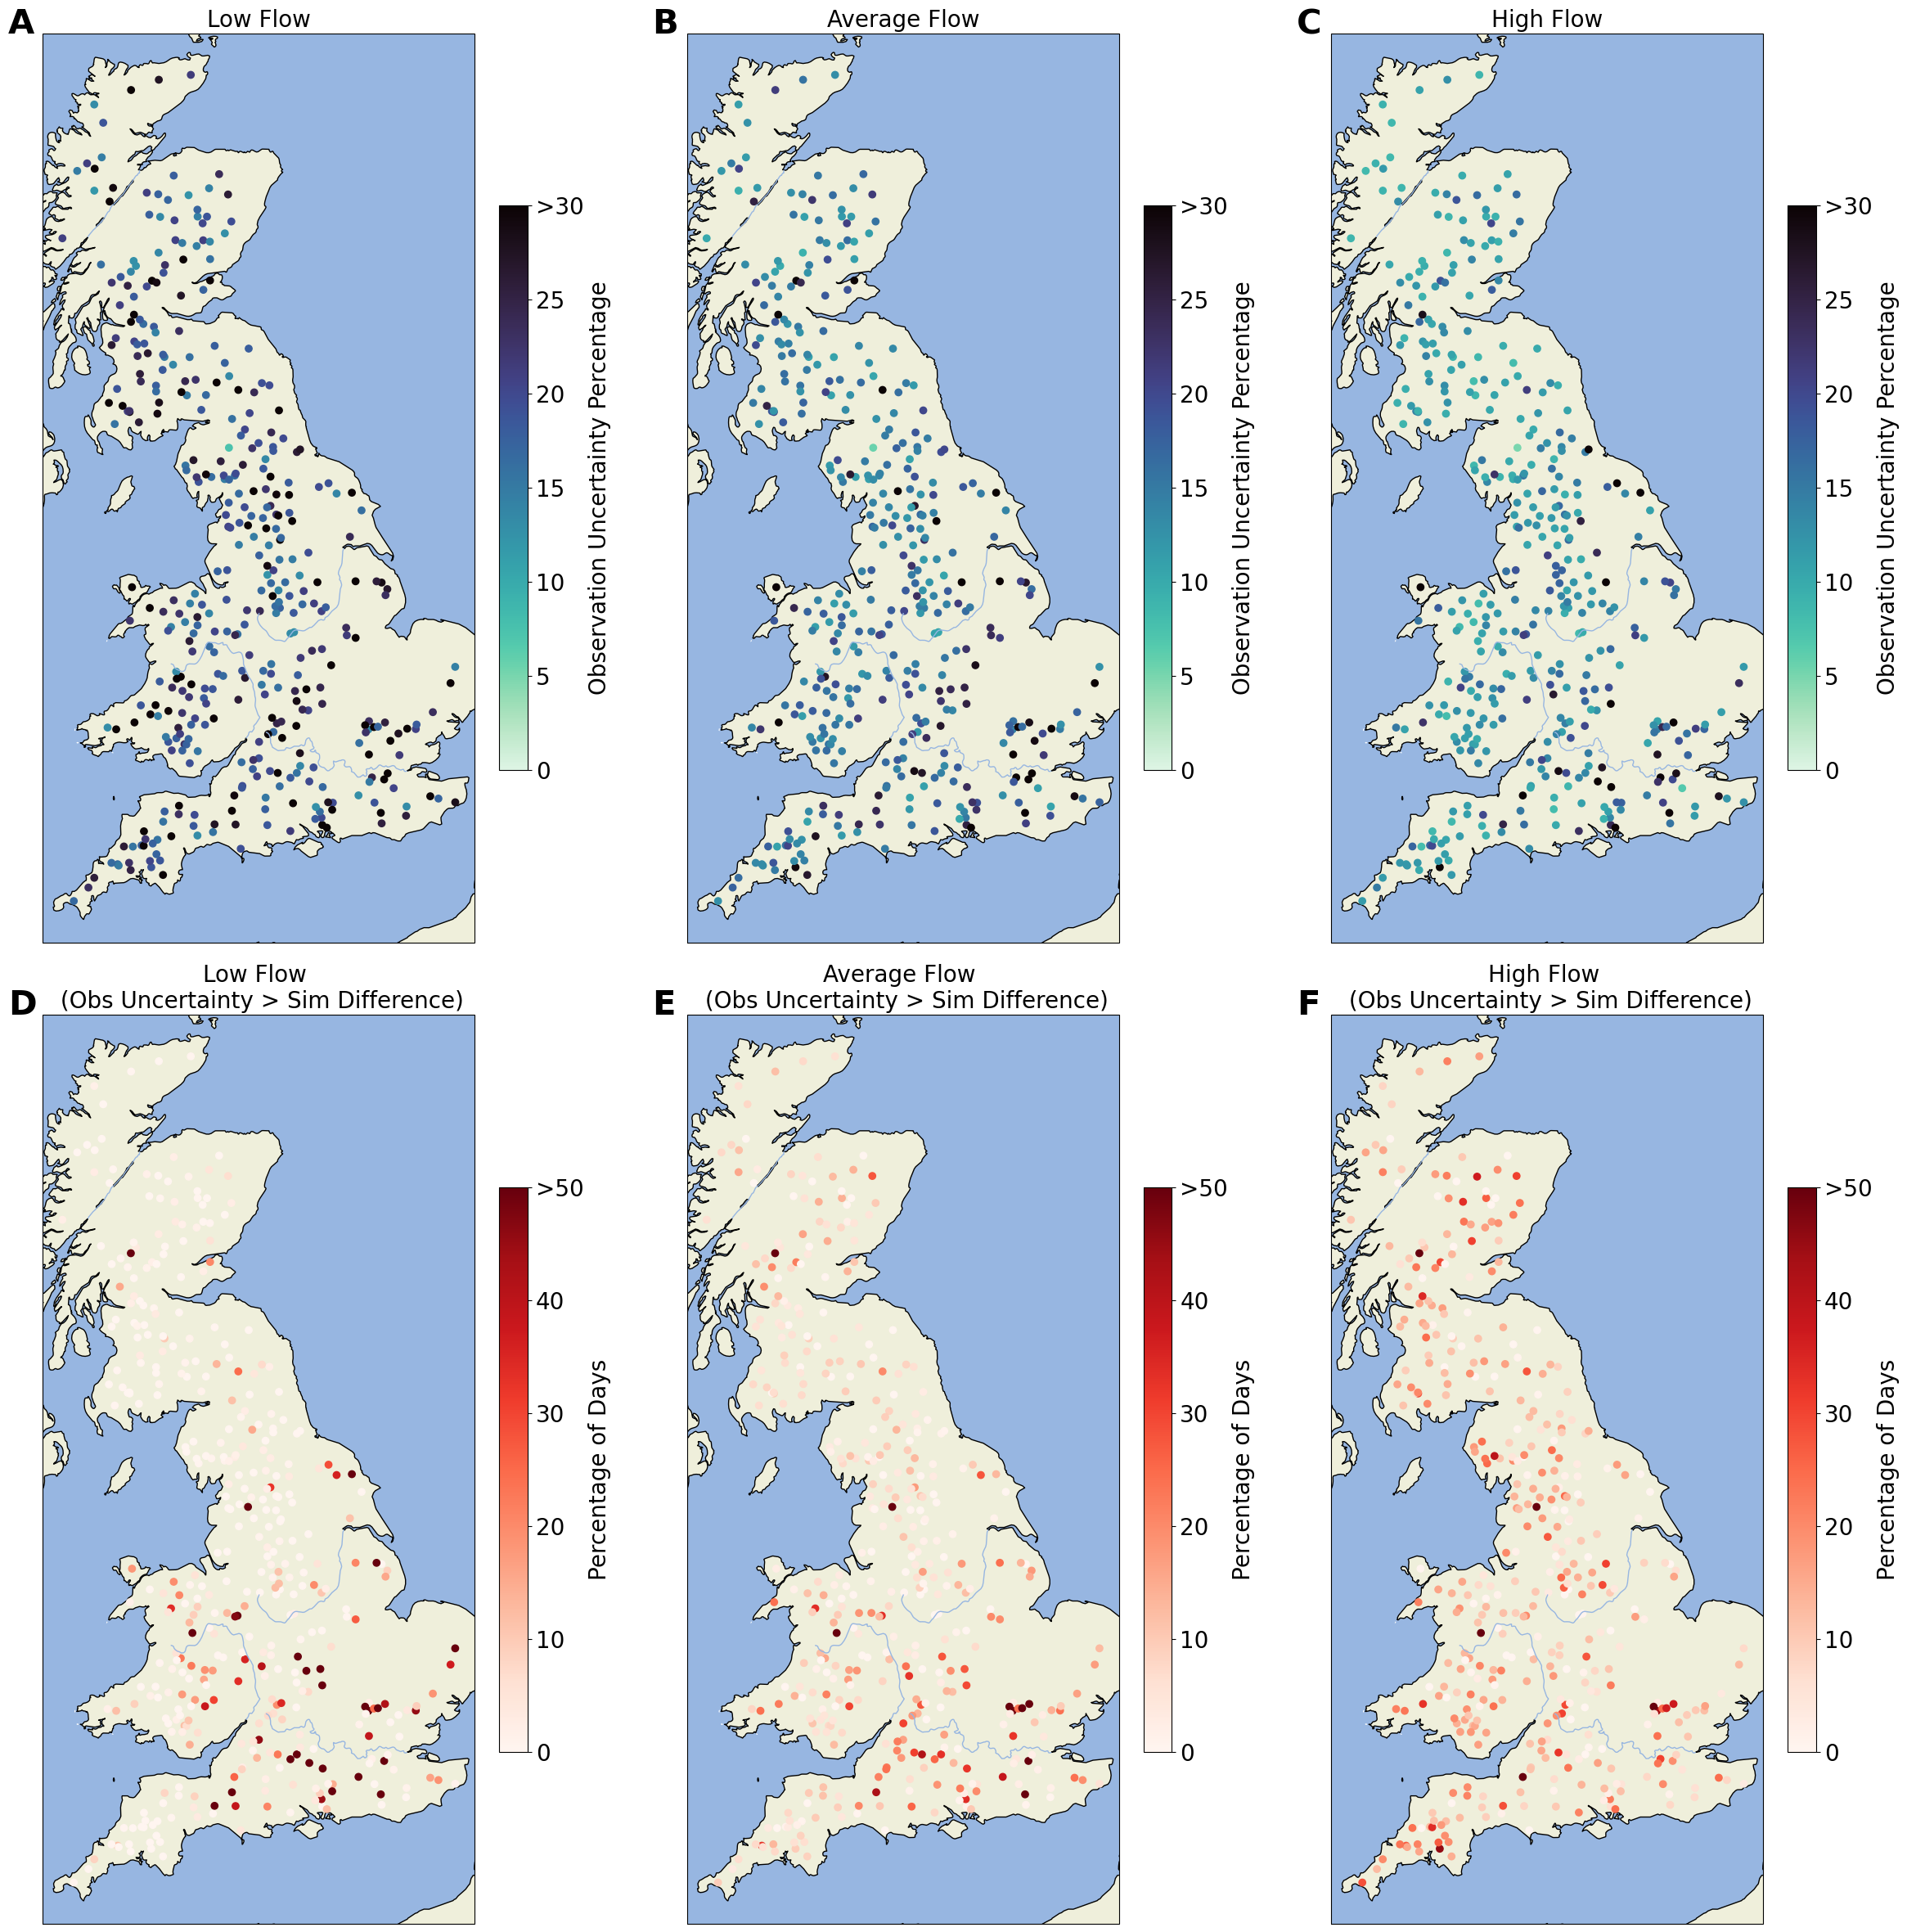

In [11]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(2, 3, figsize=(30, 30), subplot_kw={"projection": ccrs.PlateCarree(),
                                                            "aspect": "auto",
                                                             "adjustable":"box"
                                                            })
plt.subplots_adjust(wspace=0.05, hspace=0.08)
colormap1 = sns.color_palette("mako_r", as_cmap=True,)
colormap2 = 'coolwarm_r'


ax1 = gdf_low.plot(ax=axes[0,0], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax1.add_feature(cartopy.feature.RIVERS)

ax2 = gdf_mean.plot(ax=axes[0,1], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax2.add_feature(cartopy.feature.RIVERS)


ax3 = gdf_high.plot(ax=axes[0,2], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax3.add_feature(cartopy.feature.OCEAN)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax3.add_feature(cartopy.feature.RIVERS)

ax4 = gdf_low.plot(ax=axes[1,0], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax4.add_feature(cartopy.feature.OCEAN)
ax4.add_feature(cartopy.feature.LAND, edgecolor='black')
ax4.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax4.add_feature(cartopy.feature.RIVERS)

ax5 = gdf_mean.plot(ax=axes[1,1], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax5.add_feature(cartopy.feature.OCEAN)
ax5.add_feature(cartopy.feature.LAND, edgecolor='black')
ax5.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax5.add_feature(cartopy.feature.RIVERS)


ax6 = gdf_high.plot(ax=axes[1,2], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax6.add_feature(cartopy.feature.OCEAN)
ax6.add_feature(cartopy.feature.LAND, edgecolor='black')
ax6.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax6.add_feature(cartopy.feature.RIVERS)

ax1.set_title('Low Flow', size=20)
ax2.set_title('Average Flow', size=20)
ax3.set_title('High Flow', size=20)
ax4.set_title('Low Flow \n (Obs Uncertainty > Sim Difference)', size=20)
ax5.set_title('Average Flow \n (Obs Uncertainty > Sim Difference)', size=20)
ax6.set_title('High Flow \n (Obs Uncertainty > Sim Difference)', size=20)


axes[0,0].text(-0.08,1, string.ascii_uppercase[0], transform=axes[0,0].transAxes, 
            size=30, weight='bold')
axes[0,1].text(-0.08,1, string.ascii_uppercase[1], transform=axes[0,1].transAxes, 
            size=30, weight='bold')
axes[0,2].text(-0.08,1, string.ascii_uppercase[2], transform=axes[0,2].transAxes, 
            size=30, weight='bold')
axes[1,0].text(-0.08,1, string.ascii_uppercase[3], transform=axes[1,0].transAxes, 
            size=30, weight='bold')
axes[1,1].text(-0.08,1, string.ascii_uppercase[4], transform=axes[1,1].transAxes, 
            size=30, weight='bold')
axes[1,2].text(-0.08,1, string.ascii_uppercase[5], transform=axes[1,2].transAxes, 
            size=30, weight='bold')

yticks = ['0','5','10','15','20','25','>30']
colourbar = ax1.get_figure().get_axes()[6]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[7]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[8]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)

yticks = ['0','10','20','30','40','>50']
colourbar = ax1.get_figure().get_axes()[9]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[10]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[11]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)

# plt.tight_layout()
plt.savefig(f'{ROOT}/plots/fig_observation_uncertainty.png')

In [13]:
gdf_high.obs_uncertainty_percentage.median()

12.162500000000001

In [15]:
len(gdf_low[gdf_low.percentage_obs_larger > 40])

30

In [16]:
len(gdf_high[gdf_high.percentage_obs_larger > 40])

8

In [18]:
gdf_low.percentage_obs_larger.median()

0.9299999999999999

In [17]:
gdf_high.percentage_obs_larger.median()

11.885

# Plot average obs uncertainty percentage

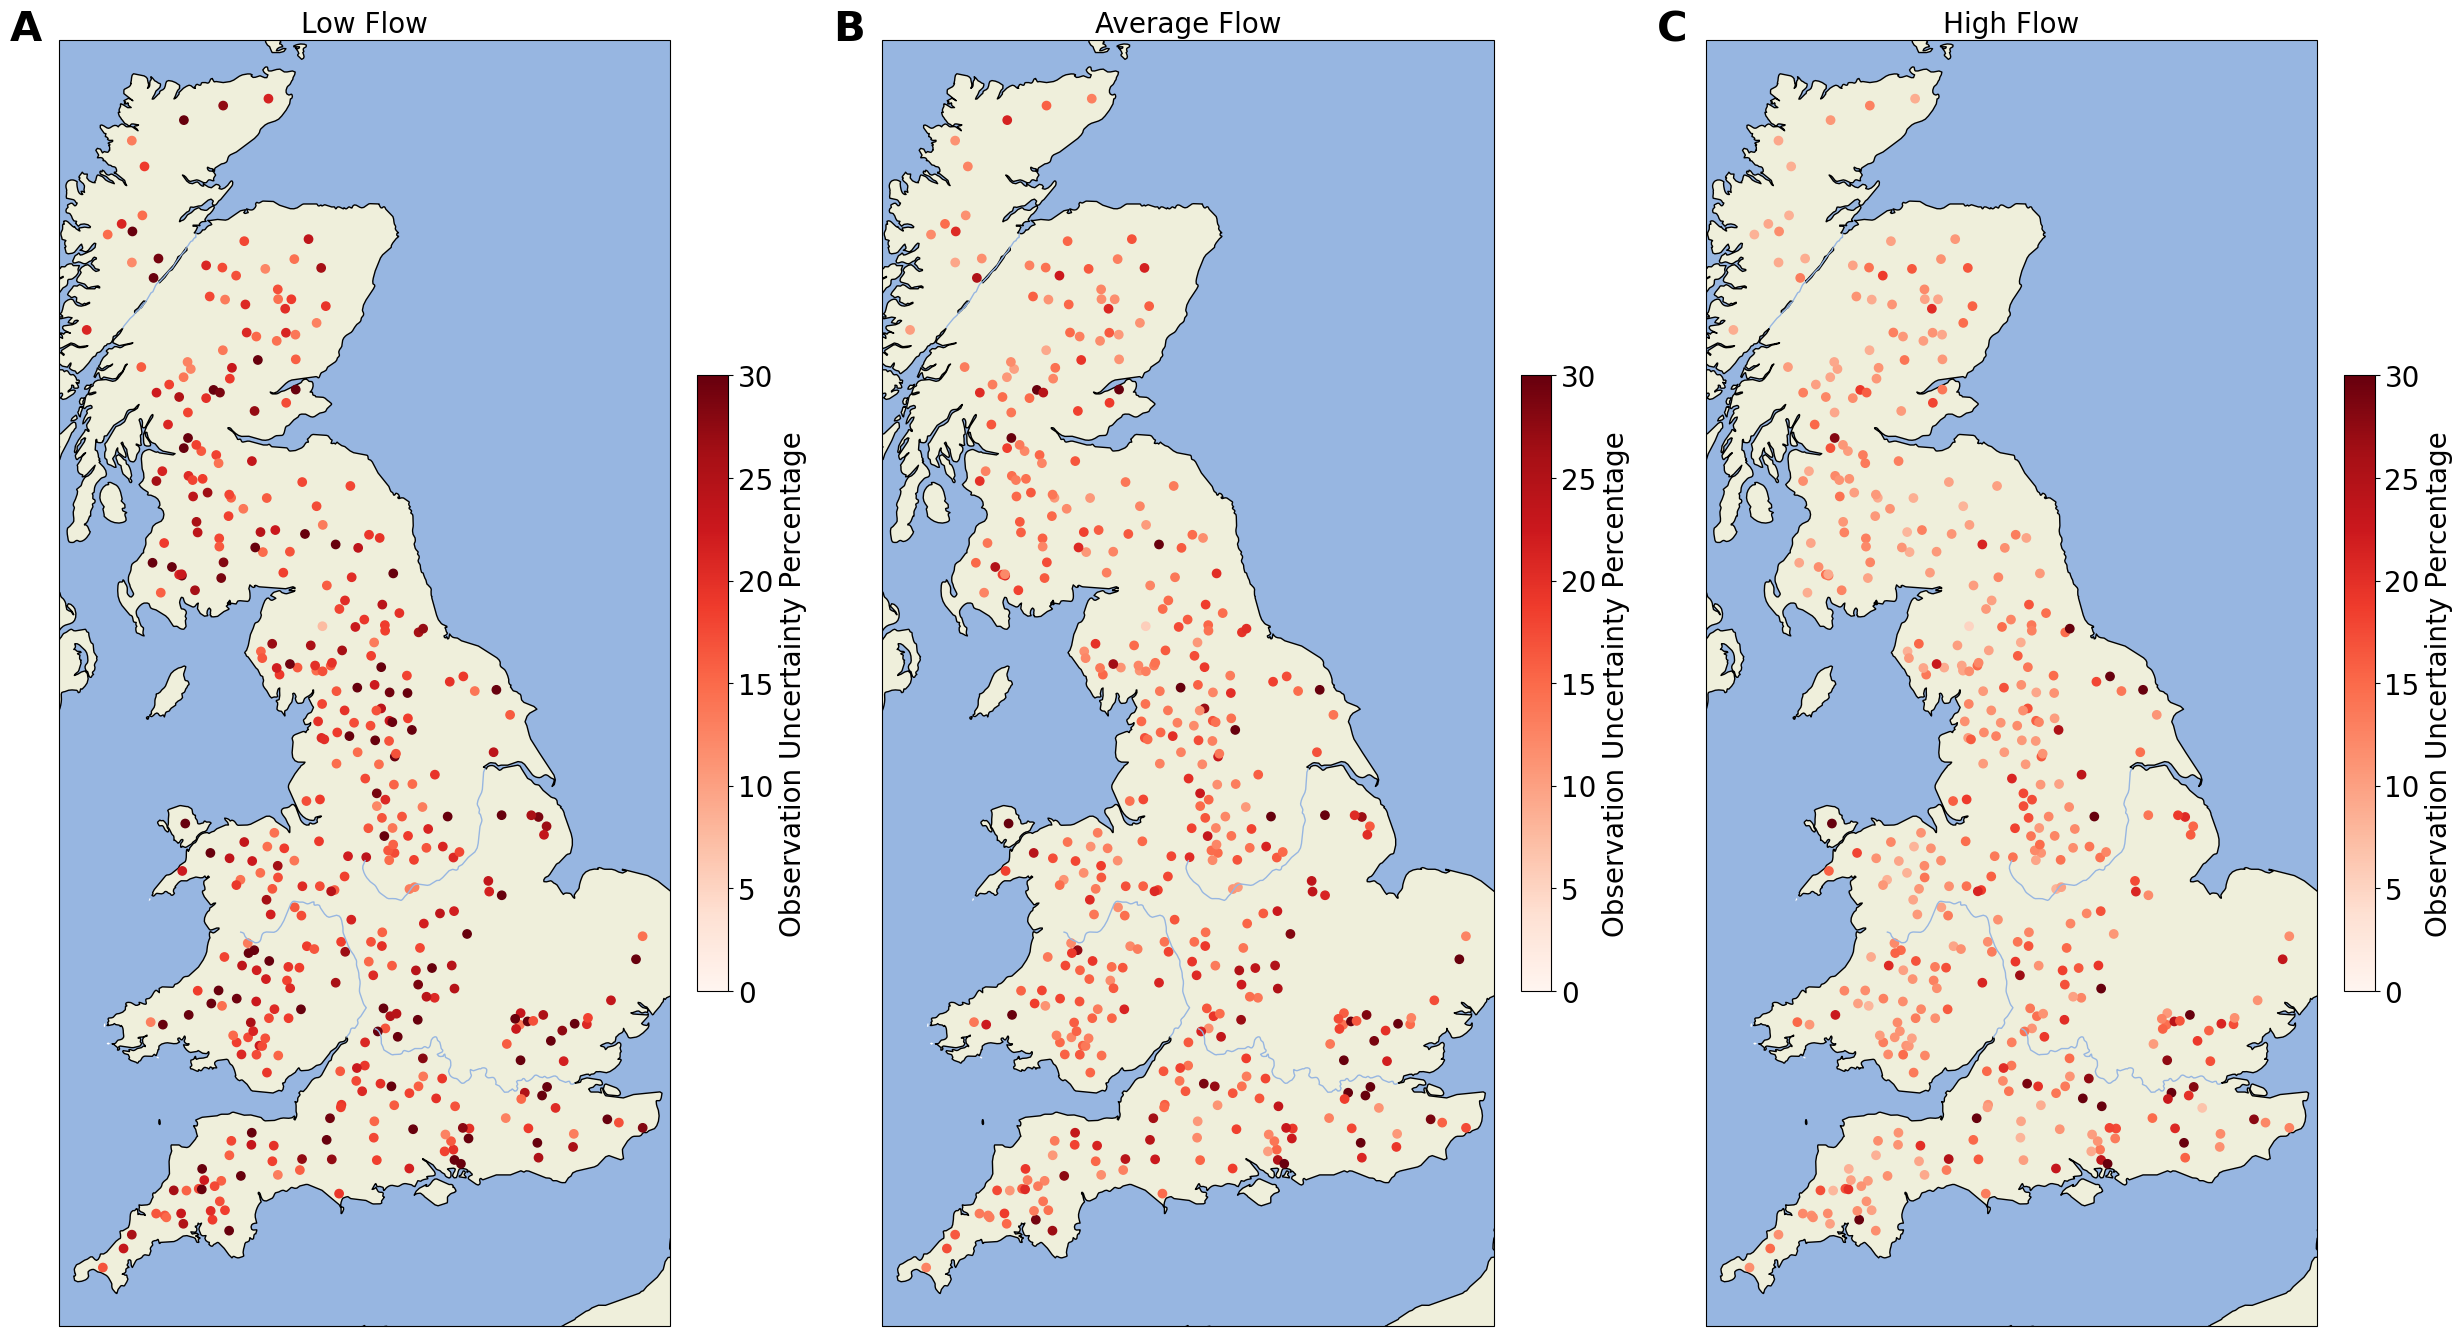

In [12]:
matplotlib.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(1, 3, figsize=(25, 30), subplot_kw={"projection": ccrs.PlateCarree(),
                                                           'aspect': 1})
plt.subplots_adjust(wspace=0.05, hspace=0.05)
colormap1 = 'summer_r'
colormap2 = 'coolwarm_r'


ax1 = gdf_low.plot(ax=axes[0], column='obs_uncertainty_percentage',
                        cmap='Reds',
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax1.add_feature(cartopy.feature.RIVERS)

ax2 = gdf_mean.plot(ax=axes[1], column='obs_uncertainty_percentage',
                        cmap='Reds',
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax2.add_feature(cartopy.feature.RIVERS)


ax3 = gdf_high.plot(ax=axes[2], column='obs_uncertainty_percentage',
                        cmap='Reds',
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax3.add_feature(cartopy.feature.OCEAN)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax3.add_feature(cartopy.feature.RIVERS)

ax1.set_title('Low Flow', size=20)
ax2.set_title('Average Flow', size=20)
ax3.set_title('High Flow', size=20)

axes[0].text(-0.08,1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
            size=30, weight='bold')
axes[1].text(-0.08,1, string.ascii_uppercase[1], transform=axes[1].transAxes, 
            size=30, weight='bold')
axes[2].text(-0.08,1, string.ascii_uppercase[2], transform=axes[2].transAxes, 
            size=30, weight='bold')



plt.tight_layout()
plt.savefig(f'{ROOT}/plots/fig_observation_uncertainty_percentage.png')

/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:155: UserWarning: FixedFormatter should only be 

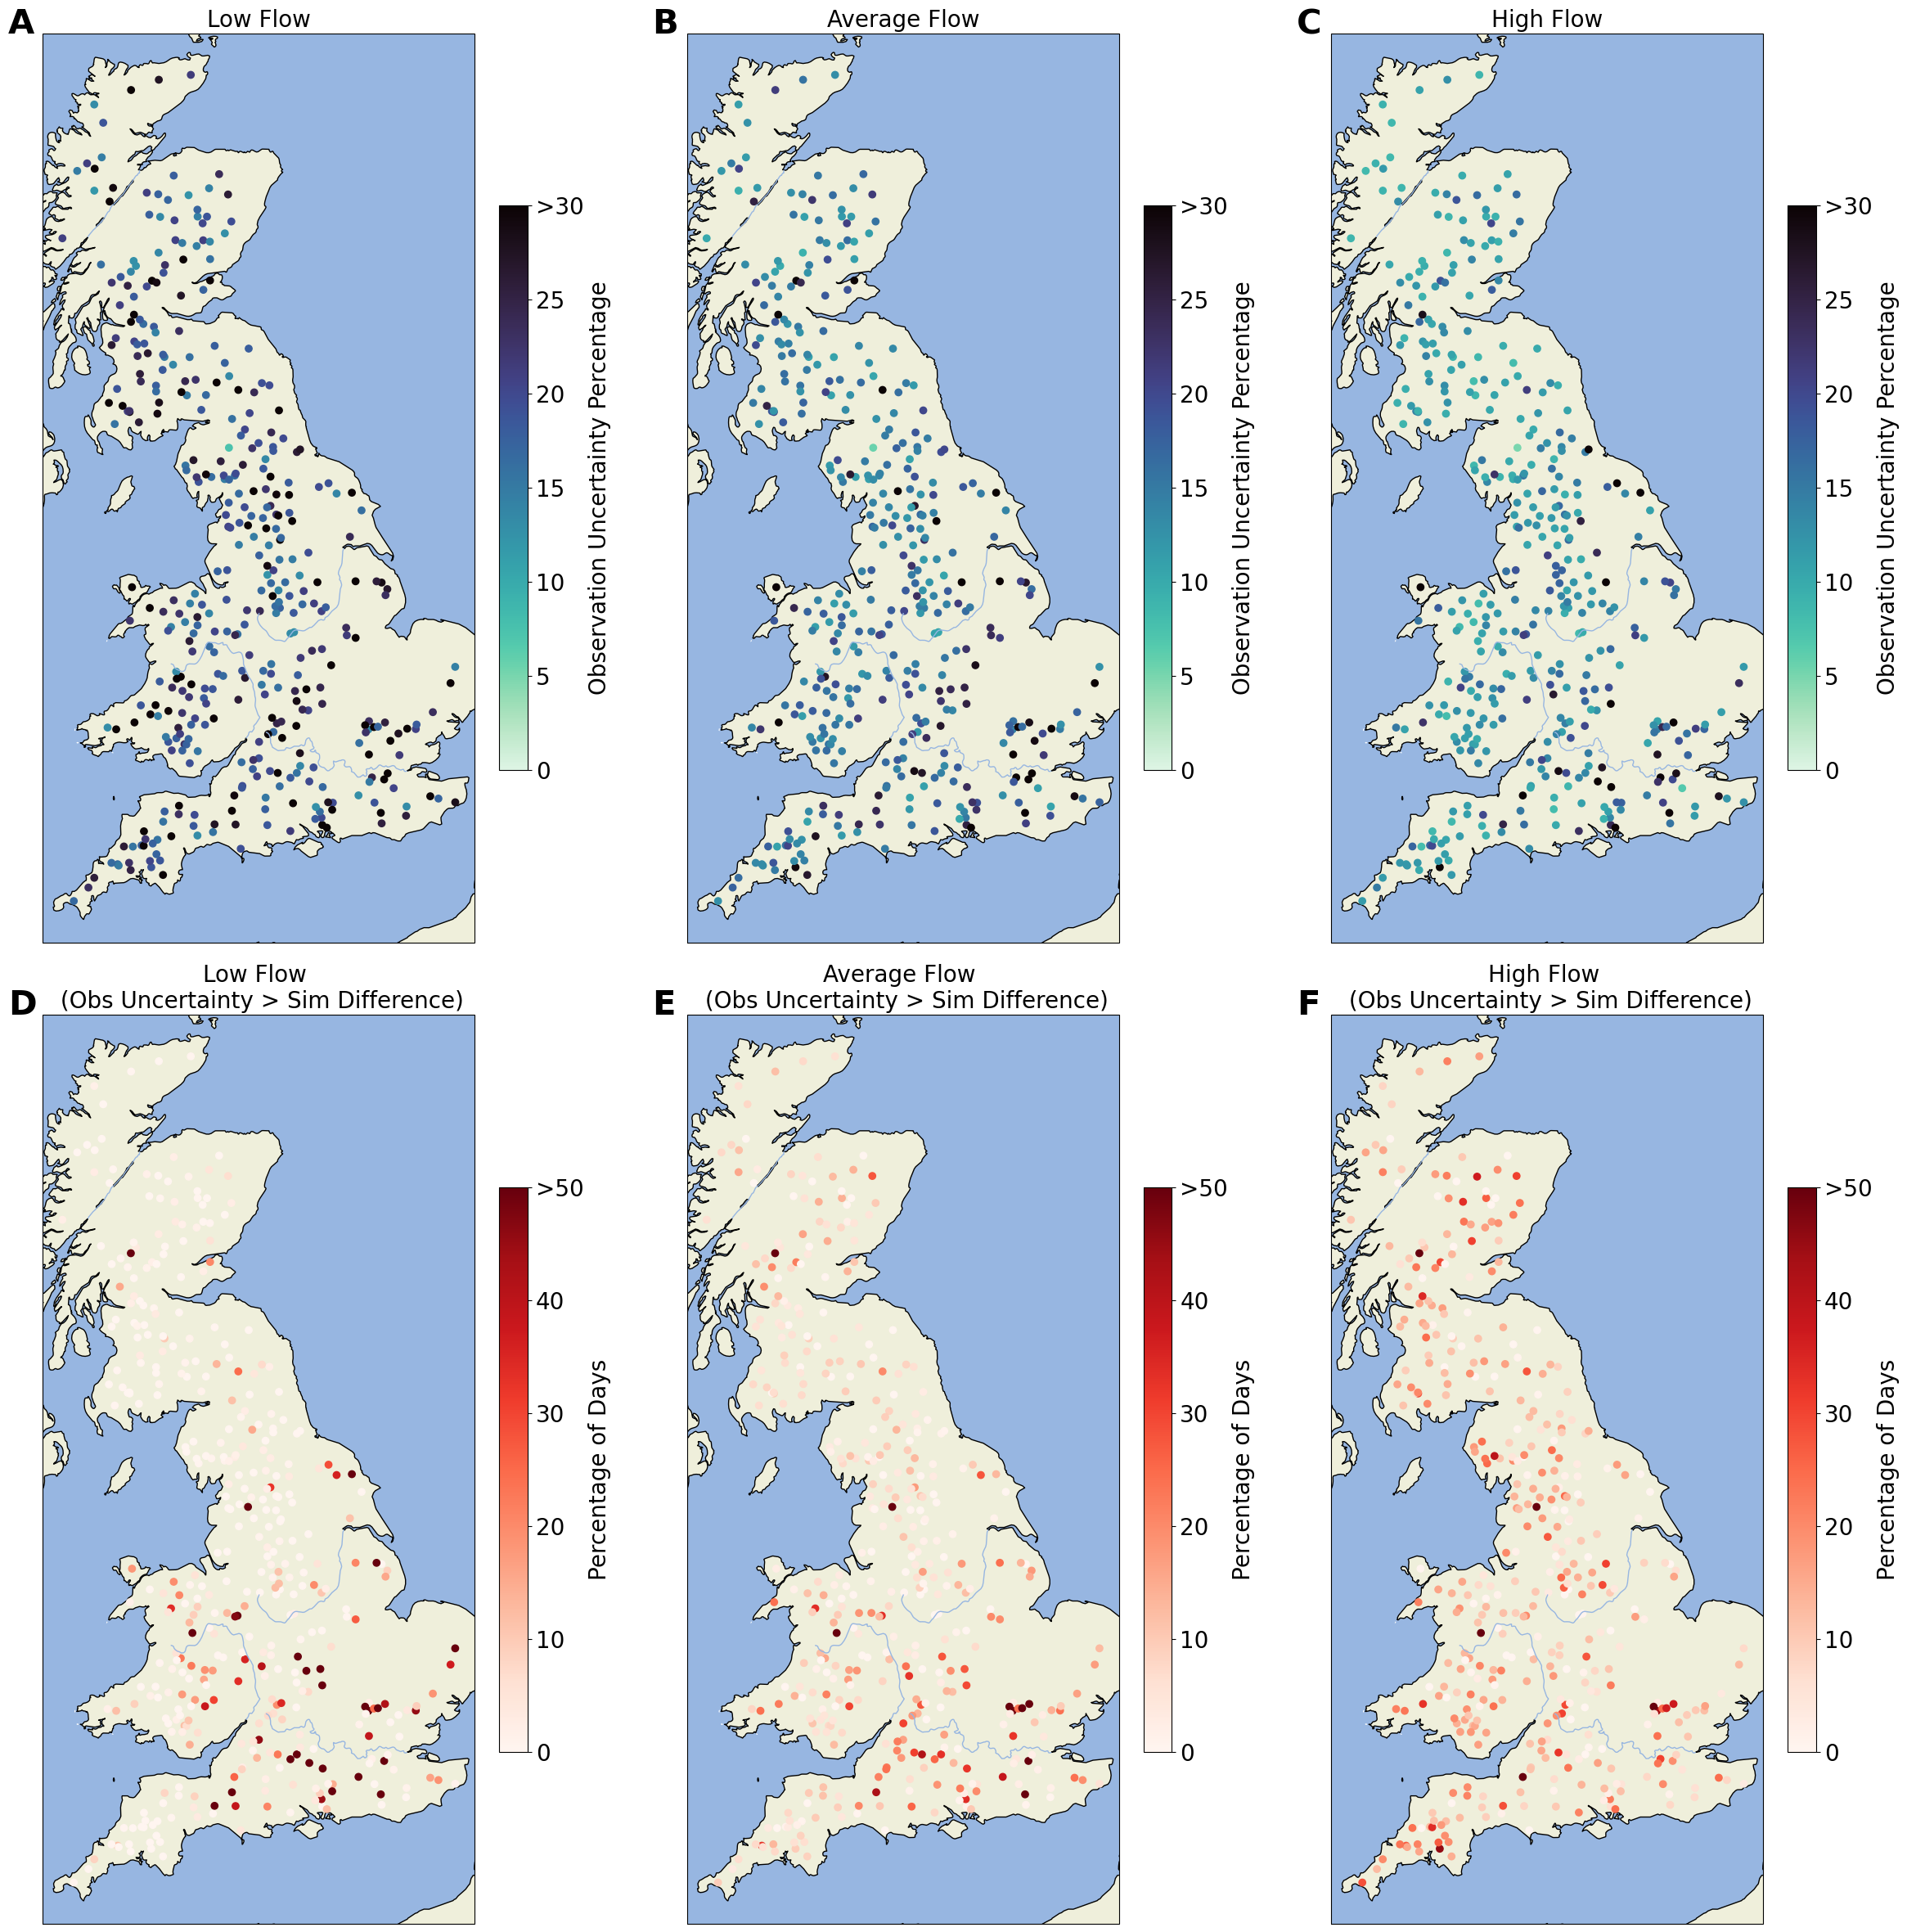

In [112]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(2, 3, figsize=(30, 30), subplot_kw={"projection": ccrs.PlateCarree(),
                                                            "aspect": "auto",
                                                             "adjustable":"box"
                                                            })
plt.subplots_adjust(wspace=0.05, hspace=0.08)
colormap1 = sns.color_palette("mako_r", as_cmap=True,)
colormap2 = 'coolwarm_r'


ax1 = gdf_low.plot(ax=axes[0,0], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax1.add_feature(cartopy.feature.RIVERS)

ax2 = gdf_mean.plot(ax=axes[0,1], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax2.add_feature(cartopy.feature.RIVERS)


ax3 = gdf_high.plot(ax=axes[0,2], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax3.add_feature(cartopy.feature.OCEAN)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax3.add_feature(cartopy.feature.RIVERS)

ax4 = gdf_low.plot(ax=axes[1,0], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax4.add_feature(cartopy.feature.OCEAN)
ax4.add_feature(cartopy.feature.LAND, edgecolor='black')
ax4.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax4.add_feature(cartopy.feature.RIVERS)

ax5 = gdf_mean.plot(ax=axes[1,1], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax5.add_feature(cartopy.feature.OCEAN)
ax5.add_feature(cartopy.feature.LAND, edgecolor='black')
ax5.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax5.add_feature(cartopy.feature.RIVERS)


ax6 = gdf_high.plot(ax=axes[1,2], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax6.add_feature(cartopy.feature.OCEAN)
ax6.add_feature(cartopy.feature.LAND, edgecolor='black')
ax6.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax6.add_feature(cartopy.feature.RIVERS)

ax1.set_title('Low Flow', size=20)
ax2.set_title('Average Flow', size=20)
ax3.set_title('High Flow', size=20)
ax4.set_title('Low Flow \n (Obs Uncertainty > Sim Difference)', size=20)
ax5.set_title('Average Flow \n (Obs Uncertainty > Sim Difference)', size=20)
ax6.set_title('High Flow \n (Obs Uncertainty > Sim Difference)', size=20)


axes[0,0].text(-0.08,1, string.ascii_uppercase[0], transform=axes[0,0].transAxes, 
            size=30, weight='bold')
axes[0,1].text(-0.08,1, string.ascii_uppercase[1], transform=axes[0,1].transAxes, 
            size=30, weight='bold')
axes[0,2].text(-0.08,1, string.ascii_uppercase[2], transform=axes[0,2].transAxes, 
            size=30, weight='bold')
axes[1,0].text(-0.08,1, string.ascii_uppercase[3], transform=axes[1,0].transAxes, 
            size=30, weight='bold')
axes[1,1].text(-0.08,1, string.ascii_uppercase[4], transform=axes[1,1].transAxes, 
            size=30, weight='bold')
axes[1,2].text(-0.08,1, string.ascii_uppercase[5], transform=axes[1,2].transAxes, 
            size=30, weight='bold')

yticks = ['0','5','10','15','20','25','>30']
colourbar = ax1.get_figure().get_axes()[6]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[7]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[8]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)

yticks = ['0','10','20','30','40','>50']
colourbar = ax1.get_figure().get_axes()[9]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[10]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[11]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)

# plt.tight_layout()
plt.savefig(f'{ROOT}/plots/fig_observation_uncertainty.png')

In [19]:
df = pd.DataFrame()

basin_ids = []
total_days = []
negative_days = []

for index, row in gdf_low.iterrows():
    basin_ids.append(index)
    total_days.append(gdf_low.loc[index].total_days + gdf_mean.loc[index].total_days + gdf_high.loc[index].total_days)
    negative_days.append(gdf_low.loc[index].negative_days + gdf_mean.loc[index].negative_days + gdf_high.loc[index].negative_days)

    
df['basin_id'] = basin_ids
df['total_days'] = total_days
df['negative_days'] = negative_days
df['percentage_days'] = (df.negative_days/df.total_days) * 100

In [20]:
gdf_low = gdf_low.join(df, rsuffix='all_cats')

/scratch-local/jaerts.1803355/ipykernel_826455/672731118.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)


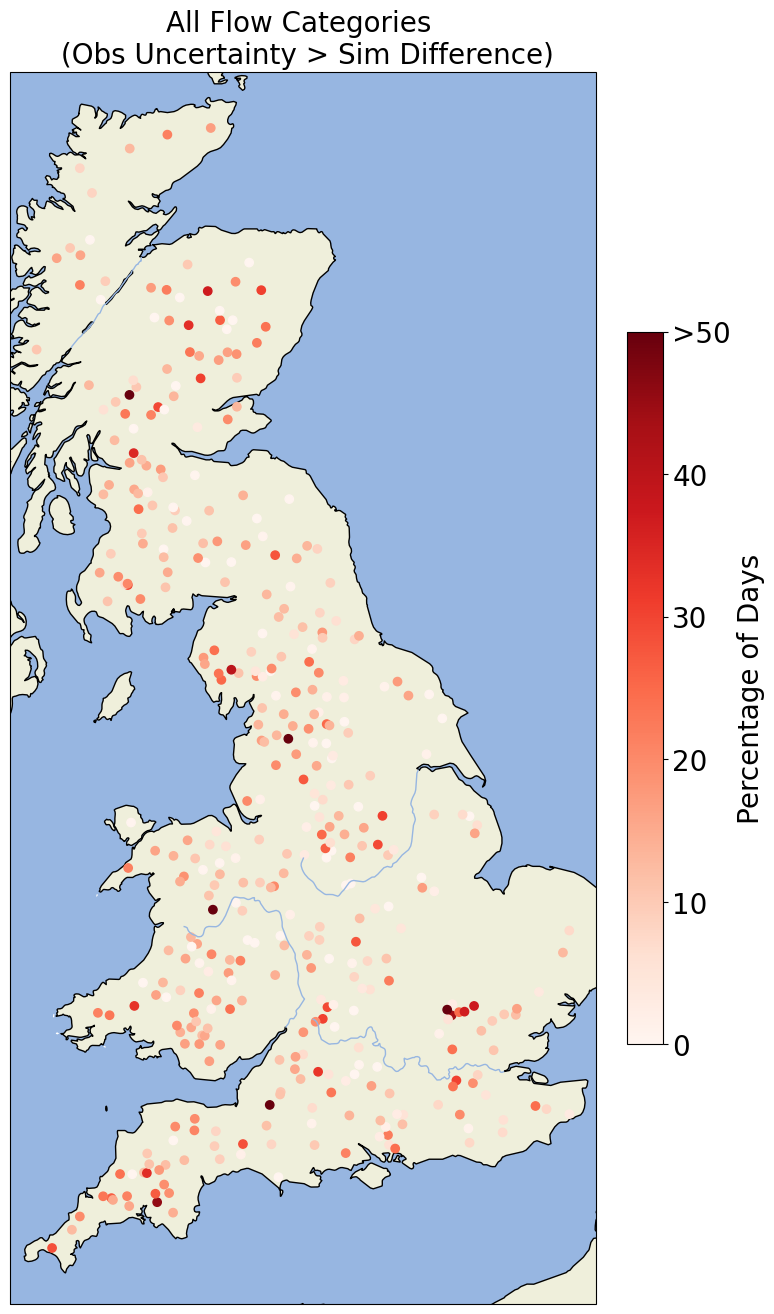

In [21]:
matplotlib.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 16), subplot_kw={"projection": ccrs.PlateCarree()})

ax = gdf_high.plot(ax=ax, column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    })


colourbar = ax.get_figure().get_axes()[1]
colourbar.get_yticks()
yticks = ['0','10','20','30','40','>50']
colourbar.set_yticklabels(yticks)

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)

# plt.tight_layout()
ax.set_title('All Flow Categories \n (Obs Uncertainty > Sim Difference)', size=20)
plt.savefig(f'{ROOT}/plots/fig_spatial_sampling_uncertainty_all_flow.png')

In [123]:
colourbar.get_yticks()

array([ 0., 10., 20., 30., 40., 50.])

In [23]:
gdf_high[gdf_high.percentage_obs_larger>20]

ID                       SOURCE VERSION    EXPORTED  \
5003    5003.0  National River Flow Archive     1.3  2018-02-12   
8004    8004.0  National River Flow Archive     1.3  2018-02-12   
8009    8009.0  National River Flow Archive     1.3  2018-02-12   
11001  11001.0  National River Flow Archive     1.3  2018-02-12   
12001  12001.0  National River Flow Archive     1.3  2018-02-12   
...        ...                          ...     ...         ...   
80003  80003.0  National River Flow Archive     1.3  2018-02-12   
80006  80006.0  National River Flow Archive     1.3  2018-02-12   
83010  83010.0  National River Flow Archive     1.3  2018-02-12   
85002  85002.0  National River Flow Archive     1.3  2018-02-12   
96001  96001.0  National River Flow Archive     1.3  2018-02-12   

                                                geometry  \
5003   POLYGON ((-4.73601 57.34958, -4.73597 57.34913...   
8004   POLYGON ((-3.35827 57.39985, -3.35832 57.40120...   
8009   POLYGON ((-3.69906 57.30183, -3.69898 57.30003...   
11001  POLYGON ((-2.18751 57.21840, -2.18751 57.21772...   
12001  POLYGON ((-2.60286 57.04978, -2.60327 57.04978...   
...                                                  ...   
80003  POLYGON ((-4.40103 55.07388, -4.40063 55.07366...   
80006  POLYGON ((-4.38582 55.08811, -4.38543 55.08812...   
83010  POLYGON ((-4.33144 55.60598, -4.33145 55.60621...   
85002  POLYGON ((-4.43475 56.04842, -4.43114 56.04849...   
96001  POLYGON ((-3.90348 58.47918, -3.90176 58.47921...   

                        centroid flow_category  obs_uncertainty_percentage  \
5003   POINT (-5.00796 57.28694)     high_flow                      9.1050   
8004   POINT (-3.38301 57.24154)     high_flow                     16.4825   
8009   POINT (-3.90588 57.25080)     high_flow                     14.1775   
11001  POINT (-2.70273 57.24834)     high_flow                     16.6300   
12001  POINT (-3.22672 57.02617)     high_flow                      9.8350   
...                          ...           ...                         ...   
80003  POINT (-4.39924 55.06125)     high_flow                     13.7625   
80006  POINT (-4.40219 55.07115)     high_flow                      9.2050   
83010  POINT (-4.26220 55.62391)     high_flow                     14.2375   
85002  POINT (-4.32424 56.03965)     high_flow                     28.1975   
96001  POINT (-3.89609 58.40205)     high_flow                     12.8075   

       total_days  negative_days  positive_days  percentage_model_larger  \
5003          511            110            401                    78.47   
8004          511            189            322                    63.01   
8009          511            112            399                    78.08   
11001         512            156            356                    69.53   
12001         511            136            375                    73.39   
...           ...            ...            ...                      ...   
80003         522            157            365                    69.92   
80006         517            106            411                    79.50   
83010         511            124            387                    75.73   
85002         511            177            334                    65.36   
96001         511            110            401                    78.47   

       percentage_obs_larger  
5003                   21.53  
8004                   36.99  
8009                   21.92  
11001                  30.47  
12001                  26.61  
...                      ...  
80003                  30.08  
80006                  20.50  
83010                  24.27  
85002                  34.64  
96001                  21.53  

[75 rows x 13 columns]

# Plot percentage of days Obs uncertainty larger than Model difference

In [ ]:
# Create uncertainty categories

unc_cat = []

for index, row in gdf_low.iterrows():
    if row.obs_uncertainty_percentage >= 0 and row.obs_uncertainty_percentage <= 10:
        unc_cat.append('Category 1')
    if row.obs_uncertainty_percentage >= 10 and row.obs_uncertainty_percentage <= 20:
        unc_cat.append('Category 2')
    if row.obs_uncertainty_percentage >= 20:
        unc_cat.append('Category 3')

gdf_low['uncertainty_cat'] = unc_cat

/home/jaerts/miniconda3/envs/wflow_state_flux/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# Create uncertainty categories

unc_cat = []

for index, row in gdf_mean.iterrows():
    if row.obs_uncertainty_percentage >= 0 and row.obs_uncertainty_percentage <= 10:
        unc_cat.append('Category 1')
    if row.obs_uncertainty_percentage >= 10 and row.obs_uncertainty_percentage <= 20:
        unc_cat.append('Category 2')
    if row.obs_uncertainty_percentage >= 20:
        unc_cat.append('Category 3')

gdf_mean['uncertainty_cat'] = unc_cat

/home/jaerts/miniconda3/envs/wflow_state_flux/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# Create uncertainty categories

unc_cat = []

for index, row in gdf_high.iterrows():
    if row.obs_uncertainty_percentage >= 0 and row.obs_uncertainty_percentage <= 10:
        unc_cat.append('Category 1')
    if row.obs_uncertainty_percentage >= 10 and row.obs_uncertainty_percentage <= 20:
        unc_cat.append('Category 2')
    if row.obs_uncertainty_percentage >= 20:
        unc_cat.append('Category 3')

gdf_high['uncertainty_cat'] = unc_cat

/home/jaerts/miniconda3/envs/wflow_state_flux/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(-0.08, 1, 'C')

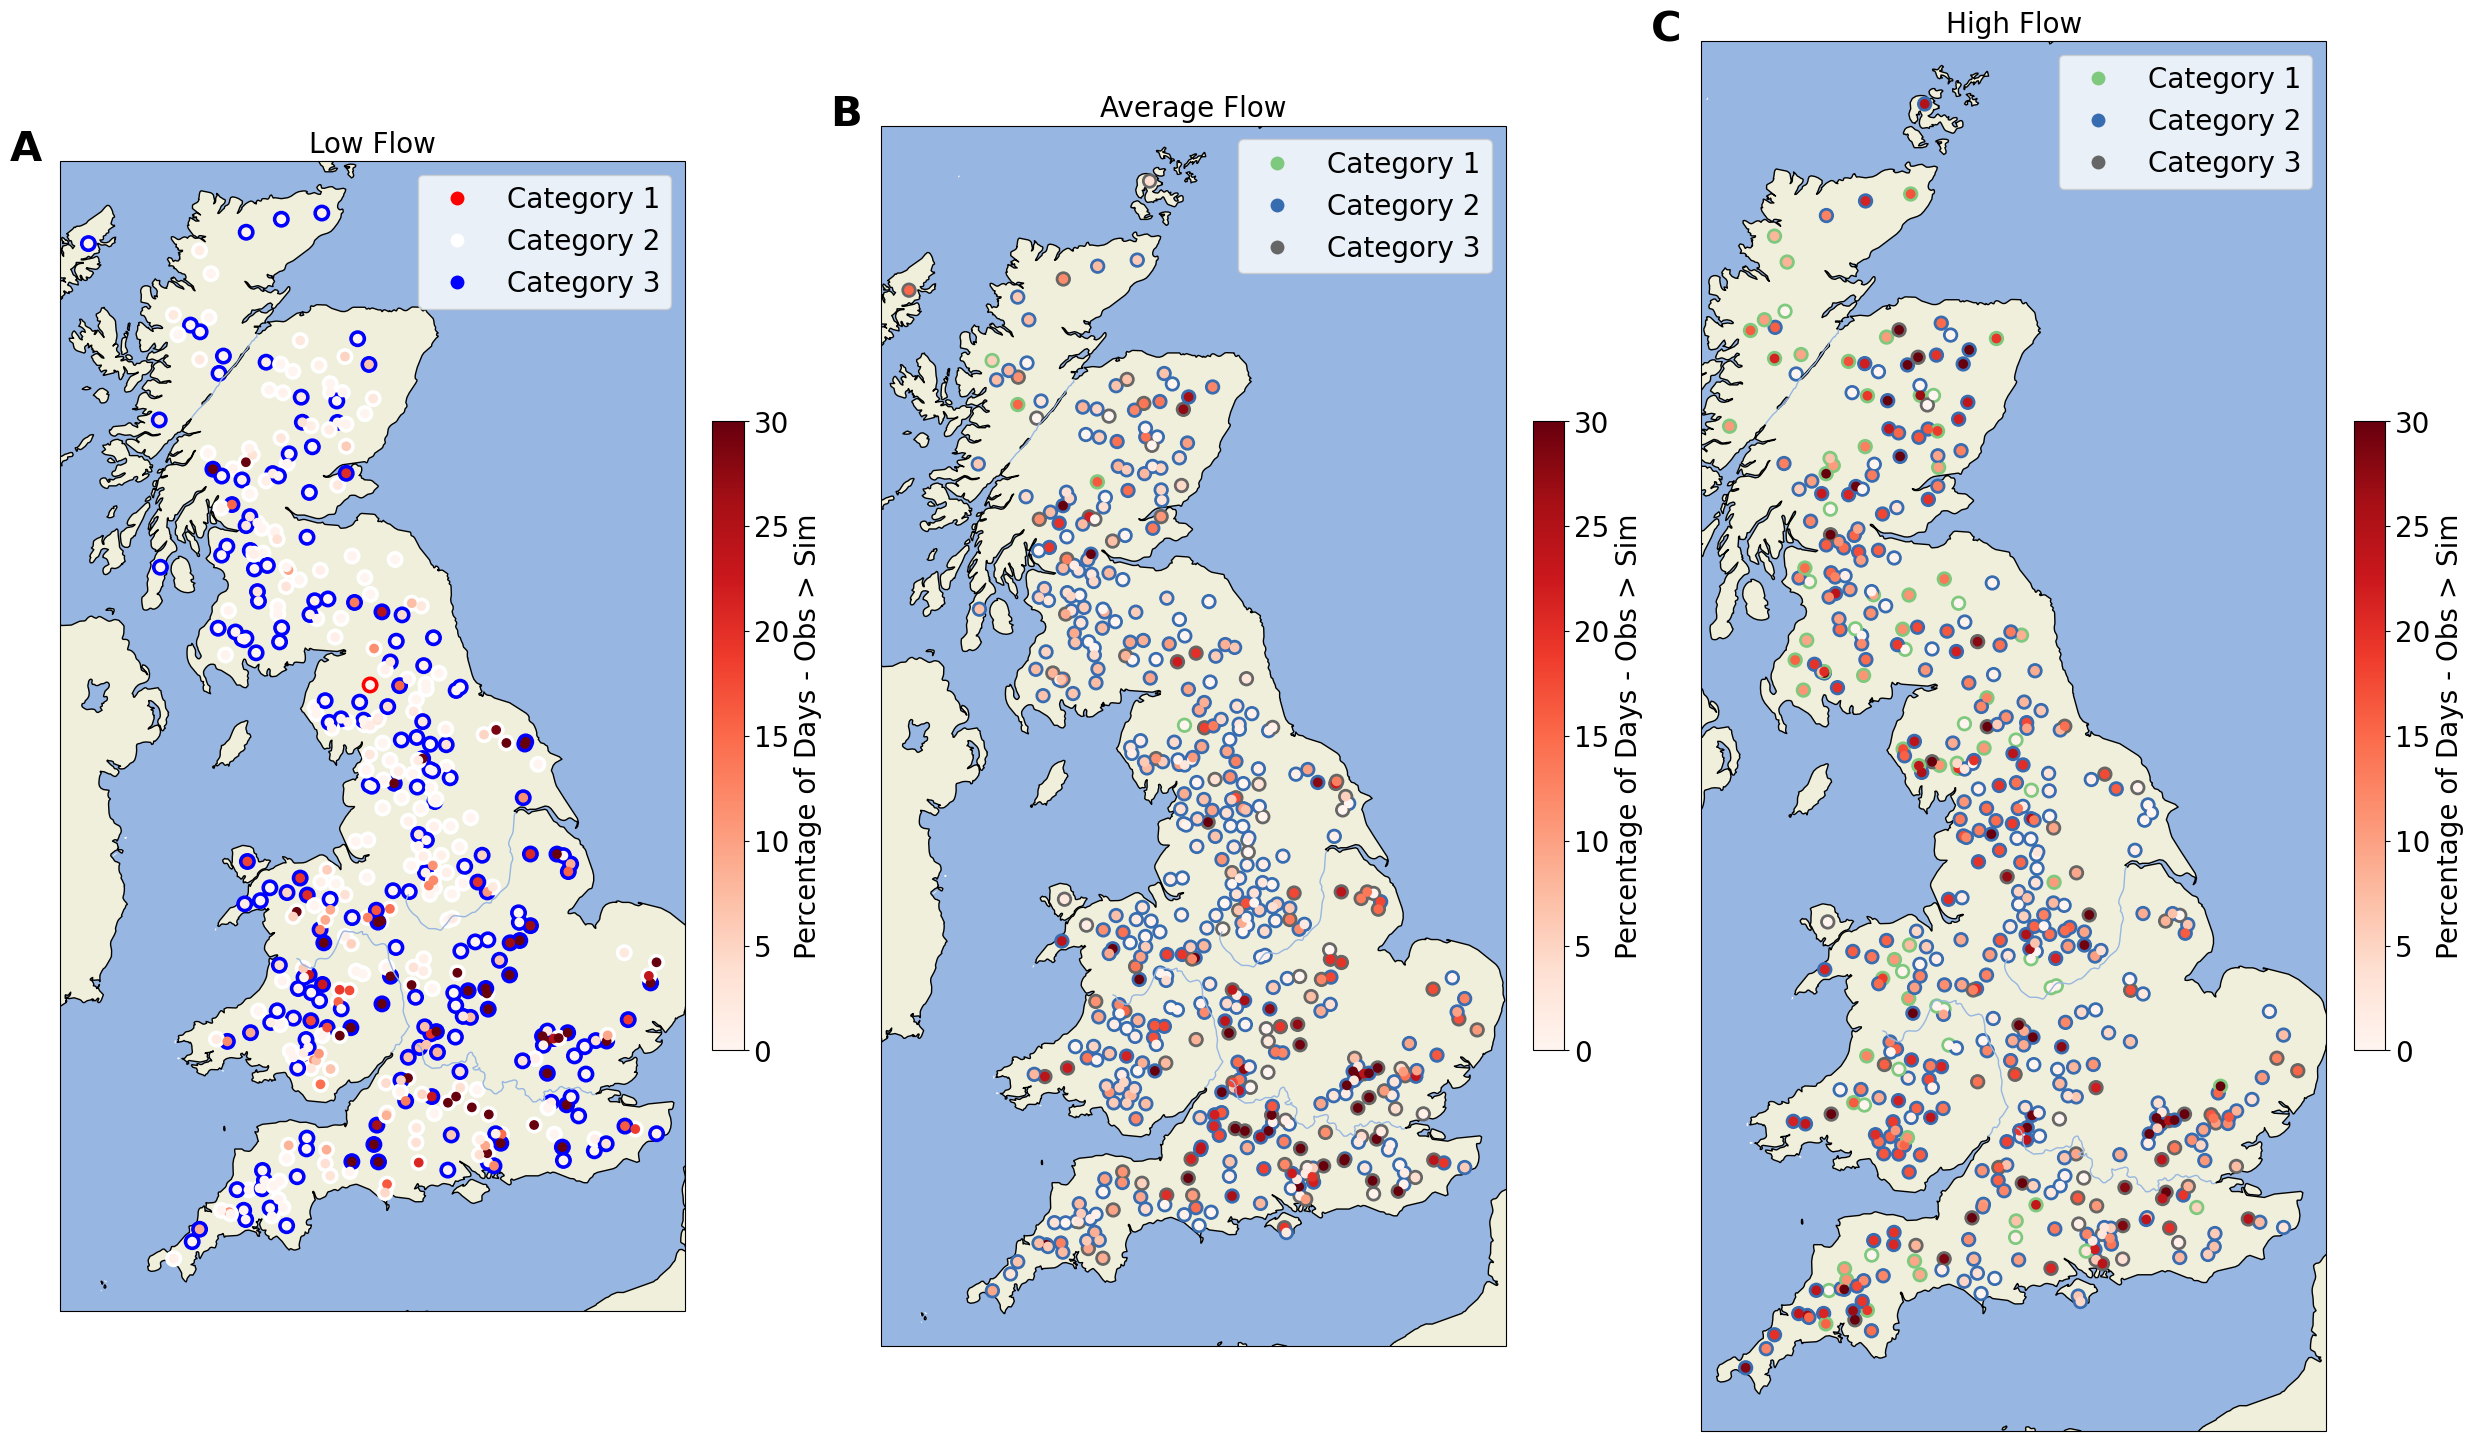

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30,30), subplot_kw={"projection": ccrs.PlateCarree(),
                                                            "aspect": "auto",
                                                             "adjustable":"box"
                                                            })

from matplotlib.colors import ListedColormap

cmp = ListedColormap(['red', 'white', 'blue'])


# plt.subplots_adjust(wspace=0.05, hspace=0.05, bottom=0.26, top=0.74)
matplotlib.rcParams.update({'font.size': 20})

ax1 = gdf_low.plot(ax=axes[0], column='uncertainty_cat',
                      cmap=cmp,
                        legend=True,
                       marker='o', facecolors='None', markersize=125)

ax1 = gdf_low.plot(ax=axes[0], column='percentage_obs_larger',
                        cmap='Reds',
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days - Obs > Sim",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")



ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax1.add_feature(cartopy.feature.RIVERS)


ax2 = gdf_mean.plot(ax=axes[1], column='uncertainty_cat',
                      cmap='Accent',
                        legend=True,
                       marker='o', facecolors='None', markersize=100)

ax2 = gdf_mean.plot(ax=axes[1], column='percentage_obs_larger',
                        cmap='Reds',
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days - Obs > Sim",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")



ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax2.add_feature(cartopy.feature.RIVERS)


ax3 = gdf_high.plot(ax=axes[2], column='uncertainty_cat',
                      cmap='Accent',
                        legend=True,
                       marker='o', facecolors='None', markersize=100)

ax3 = gdf_high.plot(ax=axes[2], column='percentage_obs_larger',
                        cmap='Reds',
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days - Obs > Sim",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")



ax3.add_feature(cartopy.feature.OCEAN)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax3.add_feature(cartopy.feature.RIVERS)

# plt.tight_layout()


ax1.set_title('Low Flow', size=20)
ax2.set_title('Average Flow', size=20)
ax3.set_title('High Flow', size=20)

axes[0].text(-0.08,1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
            size=30, weight='bold')
axes[1].text(-0.08,1, string.ascii_uppercase[1], transform=axes[1].transAxes, 
            size=30, weight='bold')
axes[2].text(-0.08,1, string.ascii_uppercase[2], transform=axes[2].transAxes, 
            size=30, weight='bold')




/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.set_yticklabels(yticks)
/scratch-local/jaerts.1783490/ipykernel_4129096/3582725583.py:155: UserWarning: FixedFormatter should only be 

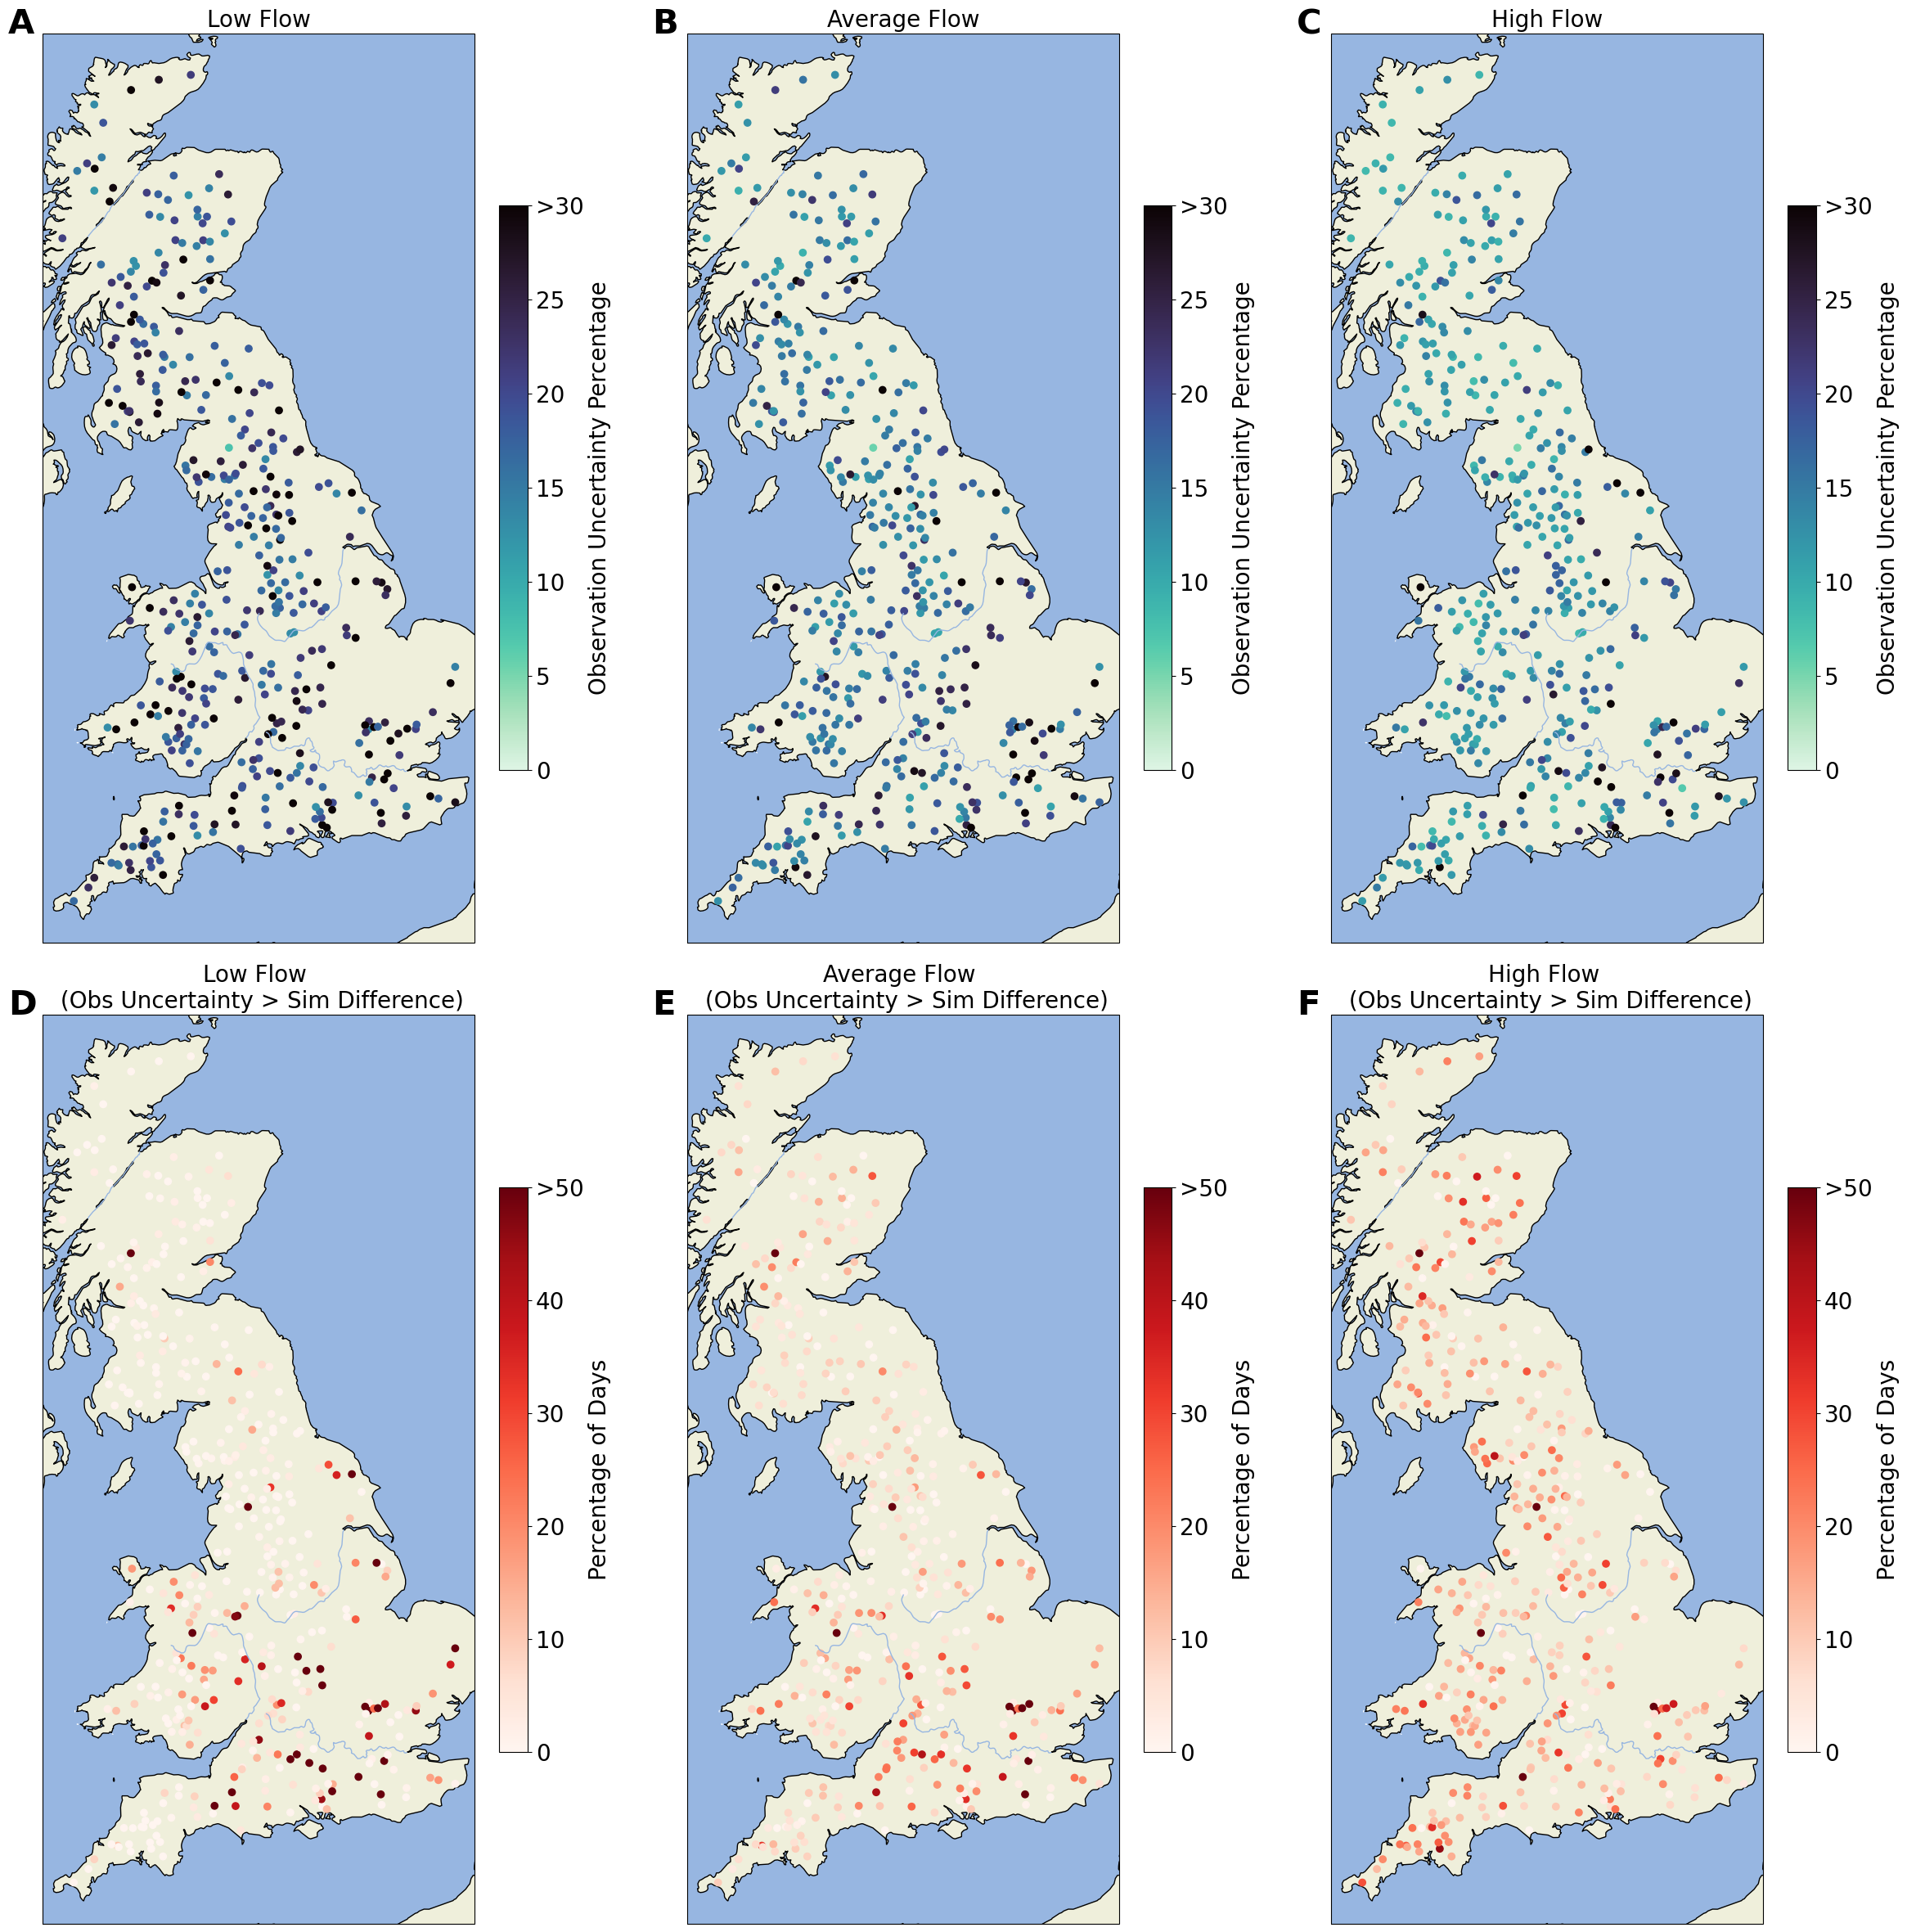

In [110]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(2, 3, figsize=(30, 30), subplot_kw={"projection": ccrs.PlateCarree(),
                                                            "aspect": "auto",
                                                             "adjustable":"box"
                                                            })
plt.subplots_adjust(wspace=0.05, hspace=0.08)
colormap1 = sns.color_palette("mako_r", as_cmap=True,)
colormap2 = 'coolwarm_r'


ax1 = gdf_low.plot(ax=axes[0,0], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax1.add_feature(cartopy.feature.RIVERS)

ax2 = gdf_mean.plot(ax=axes[0,1], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax2.add_feature(cartopy.feature.RIVERS)


ax3 = gdf_high.plot(ax=axes[0,2], column='obs_uncertainty_percentage',
                        cmap=colormap1,
                        vmin=0,
                        vmax=30,
                        legend=True,
                        legend_kwds={'label': "Observation Uncertainty Percentage",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax3.add_feature(cartopy.feature.OCEAN)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax3.add_feature(cartopy.feature.RIVERS)

ax4 = gdf_low.plot(ax=axes[1,0], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax4.add_feature(cartopy.feature.OCEAN)
ax4.add_feature(cartopy.feature.LAND, edgecolor='black')
ax4.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax4.add_feature(cartopy.feature.RIVERS)

ax5 = gdf_mean.plot(ax=axes[1,1], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax5.add_feature(cartopy.feature.OCEAN)
ax5.add_feature(cartopy.feature.LAND, edgecolor='black')
ax5.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax5.add_feature(cartopy.feature.RIVERS)


ax6 = gdf_high.plot(ax=axes[1,2], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax6.add_feature(cartopy.feature.OCEAN)
ax6.add_feature(cartopy.feature.LAND, edgecolor='black')
ax6.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax6.add_feature(cartopy.feature.RIVERS)

ax1.set_title('Low Flow', size=20)
ax2.set_title('Average Flow', size=20)
ax3.set_title('High Flow', size=20)
ax4.set_title('Low Flow \n (Obs Uncertainty > Sim Difference)', size=20)
ax5.set_title('Average Flow \n (Obs Uncertainty > Sim Difference)', size=20)
ax6.set_title('High Flow \n (Obs Uncertainty > Sim Difference)', size=20)


axes[0,0].text(-0.08,1, string.ascii_uppercase[0], transform=axes[0,0].transAxes, 
            size=30, weight='bold')
axes[0,1].text(-0.08,1, string.ascii_uppercase[1], transform=axes[0,1].transAxes, 
            size=30, weight='bold')
axes[0,2].text(-0.08,1, string.ascii_uppercase[2], transform=axes[0,2].transAxes, 
            size=30, weight='bold')
axes[1,0].text(-0.08,1, string.ascii_uppercase[3], transform=axes[1,0].transAxes, 
            size=30, weight='bold')
axes[1,1].text(-0.08,1, string.ascii_uppercase[4], transform=axes[1,1].transAxes, 
            size=30, weight='bold')
axes[1,2].text(-0.08,1, string.ascii_uppercase[5], transform=axes[1,2].transAxes, 
            size=30, weight='bold')

yticks = ['0','5','10','15','20','25','>30']
colourbar = ax1.get_figure().get_axes()[6]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[7]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[8]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)

yticks = ['0','10','20','30','40','>50']
colourbar = ax1.get_figure().get_axes()[9]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[10]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)
colourbar = ax1.get_figure().get_axes()[11]
colourbar.get_yticks()
colourbar.set_yticklabels(yticks)

# plt.tight_layout()
plt.savefig(f'{ROOT}/plots/fig_observation_uncertainty.png')

In [46]:
df = pd.DataFrame()

basin_ids = []
total_days = []
negative_days = []

for index, row in gdf_low.iterrows():
    basin_ids.append(index)
    total_days.append(gdf_low.loc[index].total_days + gdf_mean.loc[index].total_days + gdf_high.loc[index].total_days)
    negative_days.append(gdf_low.loc[index].negative_days + gdf_mean.loc[index].negative_days + gdf_high.loc[index].negative_days)

    
df['basin_id'] = basin_ids
df['total_days'] = total_days
df['negative_days'] = negative_days

KeyError: 31025

In [47]:
gdf_low

ID                       SOURCE VERSION    EXPORTED  \
1001      1001.0  National River Flow Archive     1.3  2018-02-12   
3003      3003.0  National River Flow Archive     1.3  2018-02-12   
4001      4001.0  National River Flow Archive     1.3  2018-02-12   
4005      4005.0  National River Flow Archive     1.3  2018-02-12   
4006      4006.0  National River Flow Archive     1.3  2018-02-12   
...          ...                          ...     ...         ...   
95001    95001.0  National River Flow Archive     1.3  2018-02-12   
96001    96001.0  National River Flow Archive     1.3  2018-02-12   
96002    96002.0  National River Flow Archive     1.3  2018-02-12   
102001  102001.0  National River Flow Archive     1.3  2018-02-12   
106001  106001.0  National River Flow Archive     1.3  2018-02-12   

                                                 geometry  \
1001    POLYGON ((-3.26667 58.47605, -3.26665 58.47560...   
3003    POLYGON ((-4.70053 57.96188, -4.70046 57.96099...   
4001    POLYGON ((-4.53918 57.55635, -4.53912 57.55545...   
4005    POLYGON ((-4.86378 57.53300, -4.86253 57.53303...   
4006    POLYGON ((-5.00558 57.59598, -5.00550 57.59509...   
...                                                   ...   
95001   POLYGON ((-5.15292 58.17413, -5.15249 58.17414...   
96001   POLYGON ((-3.90348 58.47918, -3.90176 58.47921...   
96002   POLYGON ((-4.20798 58.48014, -4.20627 58.48017...   
102001  POLYGON ((-4.35659 53.26534, -4.35657 53.26489...   
106001  POLYGON ((-6.42355 58.20424, -6.42440 58.20421...   

                         centroid flow_category  obs_uncertainty_percentage  \
1001    POINT (-3.34474 58.45126)      low_flow                     21.5000   
3003    POINT (-4.85415 57.96956)      low_flow                     18.7775   
4001    POINT (-4.88008 57.62165)      low_flow                     14.6250   
4005    POINT (-5.00135 57.50762)      low_flow                     36.5725   
4006    POINT (-5.13236 57.56126)      low_flow                     21.2025   
...                           ...           ...                         ...   
95001   POINT (-5.00885 58.15309)      low_flow                     13.2000   
96001   POINT (-3.89609 58.40205)      low_flow                     27.5125   
96002   POINT (-4.37443 58.29876)      low_flow                     38.9500   
102001  POINT (-4.35789 53.29947)      low_flow                     31.5050   
106001  POINT (-6.52242 58.20862)      low_flow                     37.9525   

        total_days  negative_days  positive_days  percentage_model_larger  \
1001           525              3            522                    99.43   
3003           517              1            516                    99.81   
4001           511              0            511                   100.00   
4005           519              1            518                    99.81   
4006           514              0            514                   100.00   
...            ...            ...            ...                      ...   
95001          514              9            505                    98.25   
96001          514              0            514                   100.00   
96002          511              2            509                    99.61   
102001         665            120            545                    81.95   
106001         530              3            527                    99.43   

        percentage_obs_larger uncertainty_cat  
1001                     0.57      Category 3  
3003                     0.19      Category 2  
4001                     0.00      Category 2  
4005                     0.19      Category 3  
4006                     0.00      Category 3  
...                       ...             ...  
95001                    1.75      Category 2  
96001                    0.00      Category 3  
96002                    0.39      Category 3  
102001                  18.05      Category 3  
106001                   0.57      Category 3  

[

530

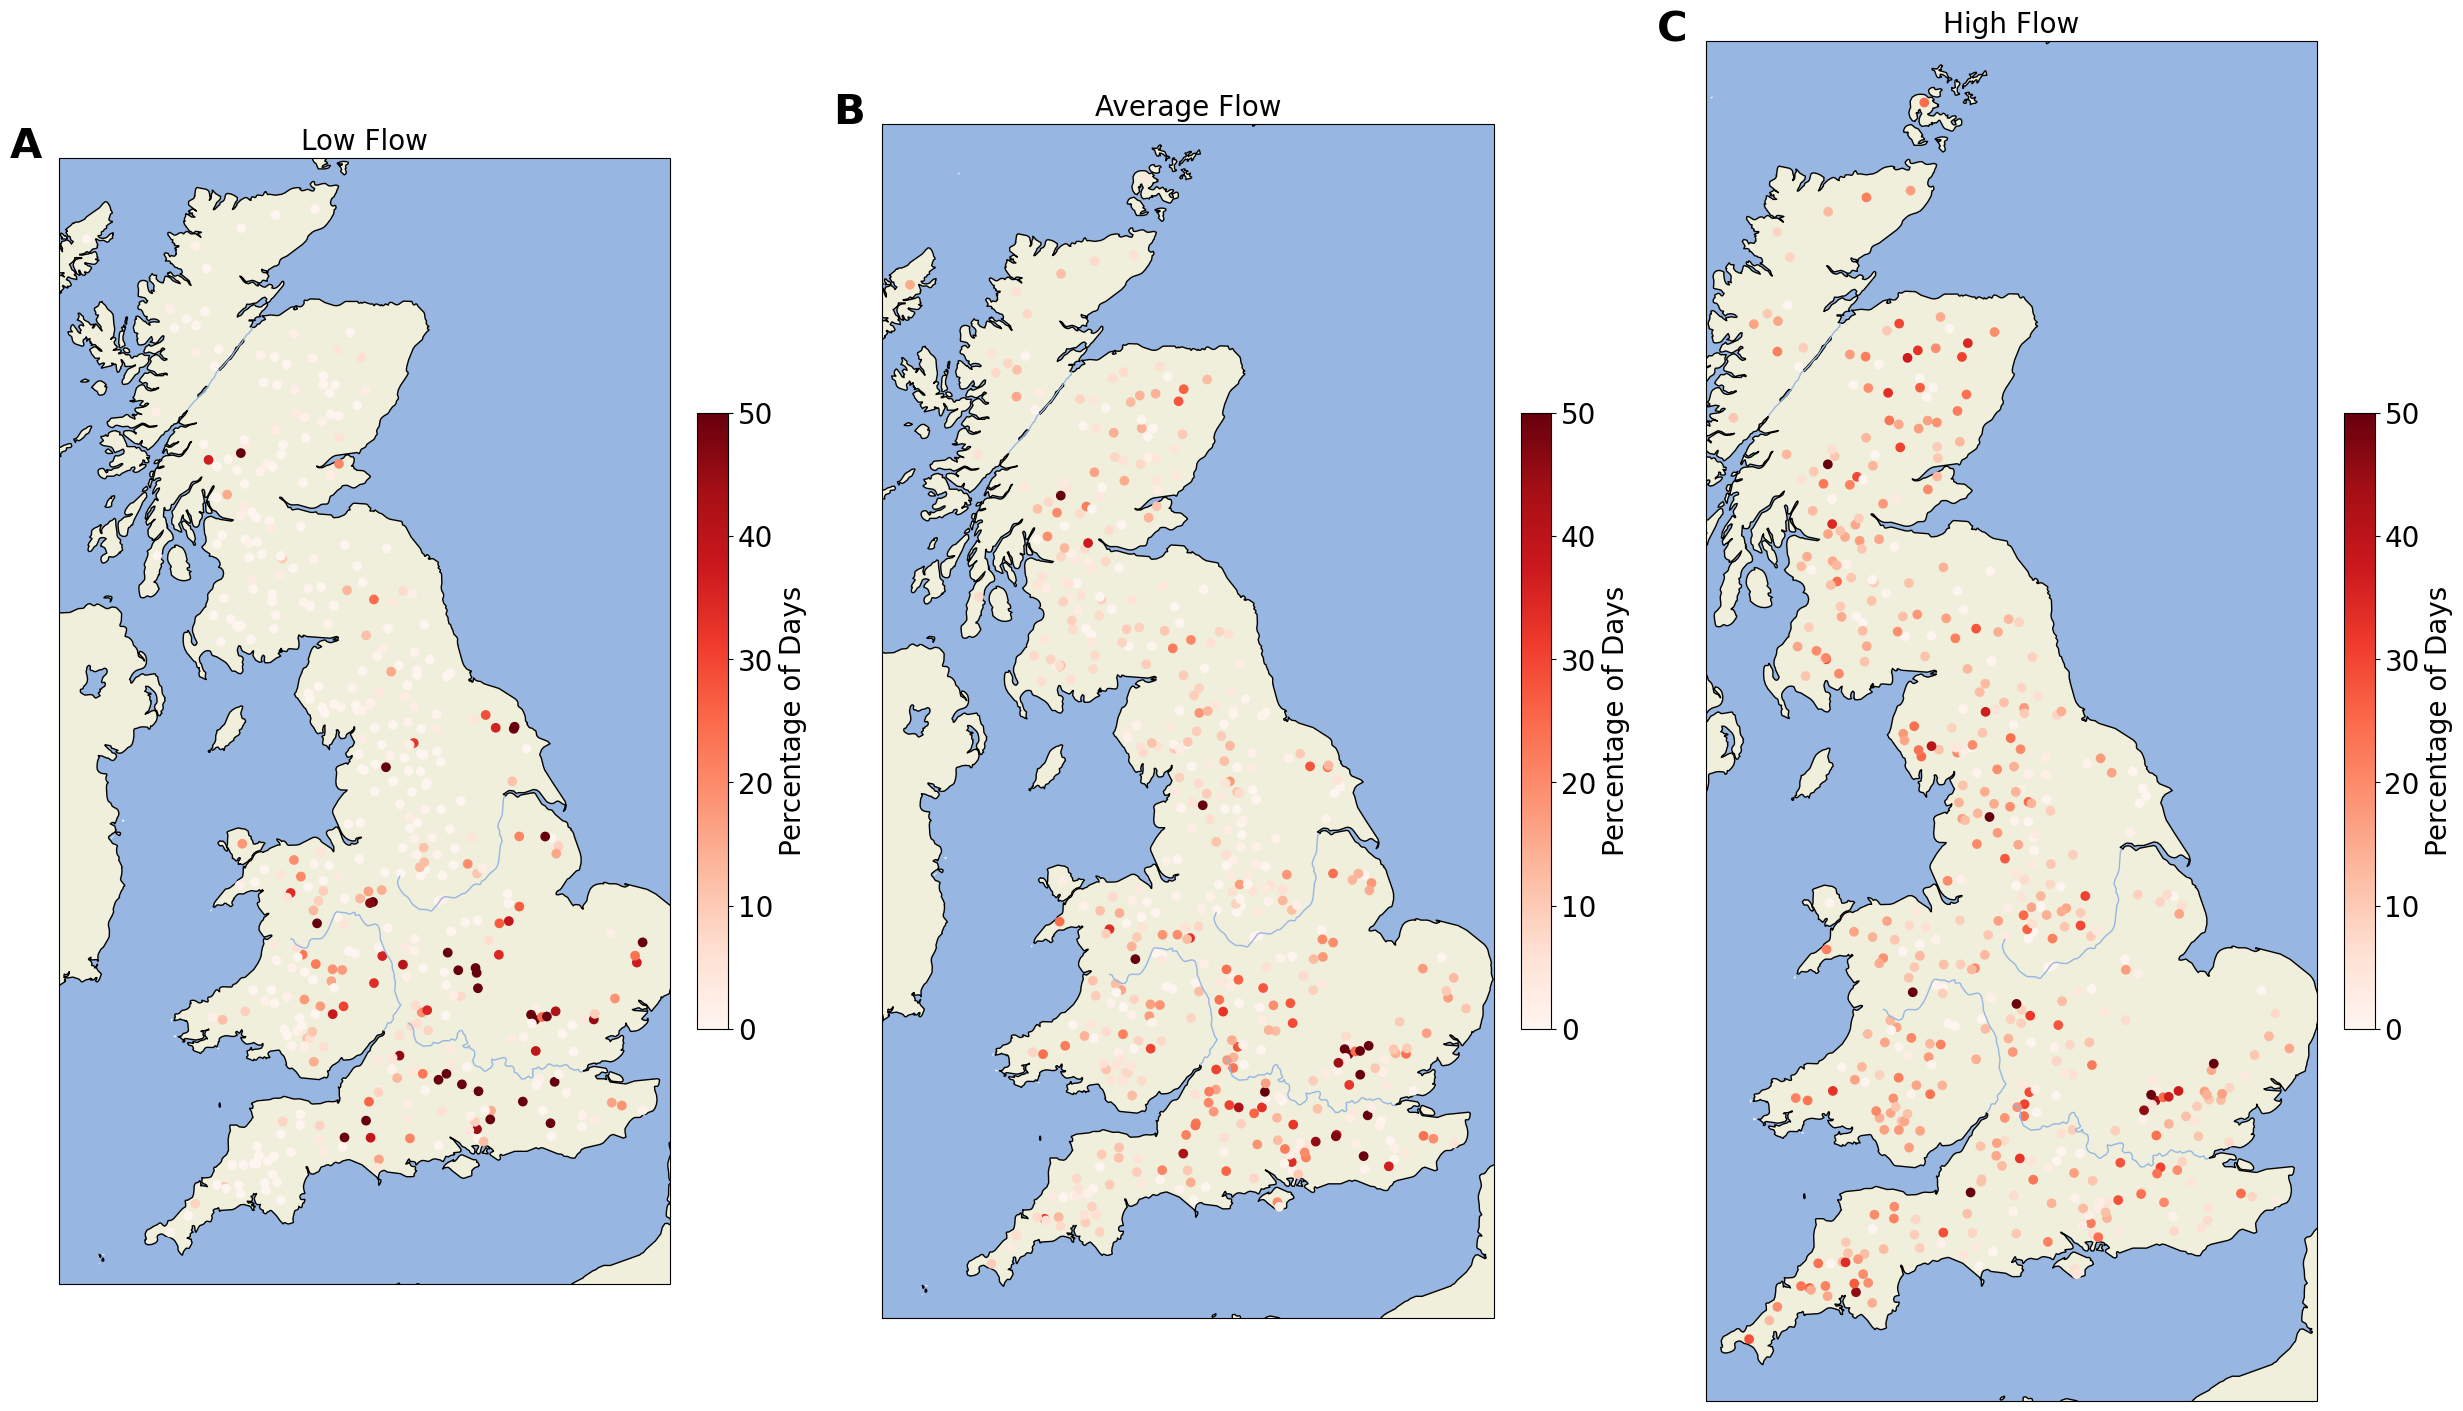

In [26]:
matplotlib.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(1, 3, figsize=(25, 30), subplot_kw={"projection": ccrs.PlateCarree(),
                                                           'aspect': 1})
plt.subplots_adjust(wspace=0.05, hspace=0.05)
colormap1 = 'summer_r'
colormap2 = 'coolwarm_r'

ax1 = gdf_low.plot(ax=axes[0], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax1.add_feature(cartopy.feature.RIVERS)

ax2 = gdf_mean.plot(ax=axes[1], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax2.add_feature(cartopy.feature.OCEAN)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax2.add_feature(cartopy.feature.RIVERS)


ax3 = gdf_high.plot(ax=axes[2], column='percentage_obs_larger',
                        cmap='Reds',
                        vmax=50,
                        legend=True,
                        legend_kwds={'label': "Percentage of Days",
                                     'orientation': "vertical",
                                      # "shrink":.5
                                     "fraction":0.046,
                                     "pad":0.04,
                                    },aspect="auto")

ax3.add_feature(cartopy.feature.OCEAN)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax3.add_feature(cartopy.feature.RIVERS)

ax1.set_title('Low Flow', size=20)
ax2.set_title('Average Flow', size=20)
ax3.set_title('High Flow', size=20)

axes[0].text(-0.08,1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
            size=30, weight='bold')
axes[1].text(-0.08,1, string.ascii_uppercase[1], transform=axes[1].transAxes, 
            size=30, weight='bold')
axes[2].text(-0.08,1, string.ascii_uppercase[2], transform=axes[2].transAxes, 
            size=30, weight='bold')

plt.tight_layout()
plt.savefig(f'{ROOT}/plots/fig_percentage_days.png')

In [27]:
fig1.axes

NameError: name 'fig1' is not defined

In [210]:
df_stats.sort_values(by='percentage_model_larger')

basin_id flow_category  total_days  negative_days  positive_days  \
525      28048      low_flow         569              0            569   
250      21008     mean_flow        1279              0           1279   
249      21008      low_flow         514              0            514   
1746     77002      low_flow         513              0            513   
1778     79006     high_flow         511              0            511   
...        ...           ...         ...            ...            ...   
155      15016     high_flow         511            511              0   
1338     54005      low_flow         516            516              0   
1661     71001     high_flow         516            516              0   
1659     71001      low_flow         514            514              0   
1339     54005     mean_flow        1281           1281              0   

      percentage_model_larger  percentage_obs_larger  
525                       0.0                  100.0  
250                       0.0                  100.0  
249                       0.0                  100.0  
1746                      0.0                  100.0  
1778                      0.0                  100.0  
...                       ...                    ...  
155                     100.0                    0.0  
1338                    100.0                    0.0  
1661                    100.0                    0.0  
1659                    100.0                    0.0  
1339                    100.0                    0.0  

[1944 rows x 7 columns]

In [110]:
df_stats = pd.DataFrame()
basins = []
categories = []
total_days = []
neg_days = []
pos_days = []
neg_perc = []
pos_perc = []

for category in flow_categories:
        files = glob(f'{ROOT}/results/categories/{category}/*_model_difference.csv')

        for file in files:
            # Read csv
            df = pd.read_csv(file)

            # Count positive and negative differences
            total_len = len(df)

            mask = df['diff-obs'] > 0
            positive_diff = df.loc[mask]
            positive_len = len(positive_diff)
            negative_len = total_len - positive_len

            if positive_len == total_len or negative_len == total_len:
                if positive_len > 0:
                    negative_percentage = 0
                    positive_percentage = 100
                if negative_len > 0:
                    negative_percentage = 100
                    positive_percentage = 0
            else:
                negative_percentage = (negative_len/total_len) * 100
                positive_percentage = (positive_len/total_len) * 100
            
            basins.append(basin_id)
            categories.append(category)

            neg_days.append(negative_len)
            pos_days.append(positive_len)
            total_days.append(total_len)

            neg_perc.append(negative_percentage)
            pos_perc.append(positive_percentage)

df_stats['basin_id'] = basins
df_stats['flow_category'] = categories
df_stats['total_days'] = total_days
df_stats['negative_days'] = neg_days
df_stats['positive_days'] = pos_days
df_stats['percentage_model_larger'] = np.round(neg_perc,2)
df_stats['percentage_obs_larger'] = np.round(pos_perc,2)

In [82]:
# Read csv
df = pd.read_csv(glob(f'{ROOT}/results/categories/{category}/{basin_id}_model_difference.csv')[0],index_col='time')

# Calculate ks statistic
statistic, pvalue = stats.ttest_ind(df.model_difference.values, df.obs_uncertainty.values, alternative='two-sided')

<AxesSubplot: xlabel='time'>

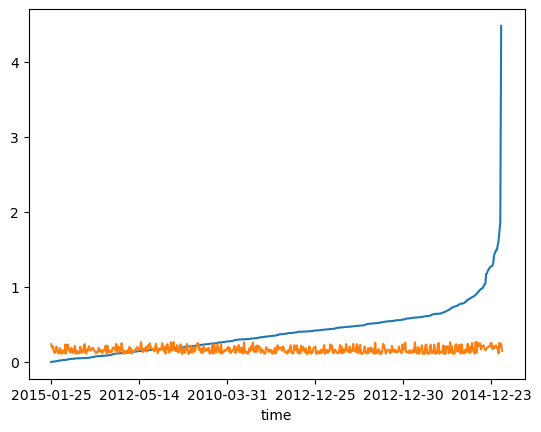

In [84]:
df = df.sort_values(by='model_difference')
df.model_difference.plot()
# df = df.sort_values(by='obs_uncertainty')
df.obs_uncertainty.plot()

In [101]:
1.521909e-10

1.521909e-10

In [97]:
basin_id = '71001'
print(basin_id)

# Get wflow_sbm simulation timeseries # CHANGE!!!
df_wflow = pd.read_csv(f"{ROOT}/results/wflow_sbm/evaluation/{basin_id}_evaluation_simulations.csv", index_col='time') 
df_wflow = df_wflow.rename(columns={'evaluation':'wflow'})

# Get pcr-globwb simulation timeseries
df_pcrglob = pd.read_csv(f"{ROOT}/results/pcr-globwb/evaluation/{basin_id}_evaluation_simulations_adjusted_location_4px.csv", index_col='time')
df_pcrglob = df_pcrglob.rename(columns={'sim':'pcrglob'})
df_pcrglob = df_pcrglob.groupby('time').mean()

# Combine to simulation dataframe
df_sim = df_wflow.join(df_pcrglob)

# # Calculate absolute difference
df_sim['model_diff'] = np.abs(df_sim['wflow']-df_sim['pcrglob'])

# Get obervation timeseries
df_obs = pd.read_csv(f'{OBSDIR}/CAMELS_GB_hydromet_timeseries_{basin_id}_19701001-20150930.csv',
                    index_col='date')

# Select evaluation period
mask = (df_obs.index >= start_date) & (df_obs.index <= end_date)
df_obs = df_obs.loc[mask]

# Drop NaN values
df_obs = df_obs[df_obs['discharge_vol'].notna()]

# Calculate percentiles
lower = flow_categories[category][0]
upper = flow_categories[category][1]

obs_perc_lower = np.percentile(df_obs.discharge_vol,lower,axis=0)
obs_perc_upper = np.percentile(df_obs.discharge_vol,upper,axis=0)

# Select obs based on percentiles
mask = (df_obs.discharge_vol >= obs_perc_lower) & (df_obs.discharge_vol <= obs_perc_upper)
df_obs_selected = df_obs.loc[mask]

71001


In [98]:
# Join model difference based on obs percentiles
df_joined = df_obs_selected.join(df_sim)

# Average upper and lower streamflow uncertainties per category
df_uncertainty = pd.read_csv(uncertainty_file, index_col='gauge_id').loc[int(basin_id)]

# In percentages uncertainty
uncertainty_lower = (np.abs(df_uncertainty[f'q{lower}_uncert_lower']) + np.abs(df_uncertainty[f'q{lower}_uncert_upper'])) / 2
uncertainty_upper = (np.abs(df_uncertainty[f'q{upper}_uncert_lower']) + np.abs(df_uncertainty[f'q{upper}_uncert_upper'])) / 2
uncertainy_average = np.mean([uncertainty_lower, uncertainty_upper])

# Get obs uncertainy values
df_obs_uncertainty = df_obs_selected * (uncertainy_average/100)

In [100]:
df_obs_uncertainty

precipitation       pet  temperature  discharge_spec  \
date                                                               
2008-10-02       0.243955  0.122616     0.888966        0.671833   
2008-10-06       0.200528  0.080467     0.968156        0.449592   
2008-10-07       2.313100  0.079189     1.601671        0.890243   
2008-10-08       0.012773  0.117507     1.259368        0.772736   
2008-10-11       0.022991  0.090685     1.532700        0.798281   
...                   ...       ...          ...             ...   
2015-06-02       0.348689  0.335917     1.323231        0.831490   
2015-07-28       0.586258  0.212024     1.449679        0.563267   
2015-08-22       1.229992  0.208192     2.095967        0.484078   
2015-08-23       1.872449  0.303986     2.088304        0.731864   
2015-08-24       0.019159  0.195419     1.702574        0.436820   

            discharge_vol      peti  humidity  shortwave_rad  longwave_rad  \
date                                                                         
2008-10-02       8.902433  0.143052  0.650120      14.275823     37.053023   
2008-10-06       5.964758  0.095794  0.747191      10.914101     39.298428   
2008-10-07      11.801790  0.100903  1.080554       6.673631     45.012845   
2008-10-08      10.243545  0.129002  0.808499      14.807159     37.761896   
2008-10-11      10.575630  0.098348  0.980928       7.230512     43.997431   
...                   ...       ...       ...            ...           ...   
2015-06-02      11.022668  0.374234  0.774014      27.812119     40.634431   
2015-07-28       7.459140  0.235014  0.927284      17.460007     43.689614   
2015-08-22       6.411795  0.222242  1.282359      15.899208     46.384611   
2015-08-23       9.694328  0.326976  1.215942      22.802744     44.153255   
2015-08-24       5.785942  0.196697  1.038404      15.993725     44.337179   

            windspeed  
date                   
2008-10-02   0.445760  
2008-10-06   0.379343  
2008-10-07   0.671833  
2008-10-08   0.404888  
2008-10-11   0.440651  
...               ...  
2015-06-02   1.017968  
2015-07-28   0.489187  
2015-08-22   0.303986  
2015-08-23   0.568376  
2015-08-24   0.274609  

[516 rows x 10 columns]

In [96]:
(uncertainy_average/100)*70

8.94075

In [93]:
df_obs_selected

precipitation   pet  temperature  discharge_spec  discharge_vol  \
date                                                                          
2008-10-02           1.91  0.96         6.96            5.26           69.7   
2008-10-06           1.57  0.63         7.58            3.52           46.7   
2008-10-07          18.11  0.62        12.54            6.97           92.4   
2008-10-08           0.10  0.92         9.86            6.05           80.2   
2008-10-11           0.18  0.71        12.00            6.25           82.8   
...                   ...   ...          ...             ...            ...   
2015-06-02           2.73  2.63        10.36            6.51           86.3   
2015-07-28           4.59  1.66        11.35            4.41           58.4   
2015-08-22           9.63  1.63        16.41            3.79           50.2   
2015-08-23          14.66  2.38        16.35            5.73           75.9   
2015-08-24           0.15  1.53        13.33            3.42           45.3   

            peti  humidity  shortwave_rad  longwave_rad  windspeed  
date                                                                
2008-10-02  1.12      5.09         111.77        290.10       3.49  
2008-10-06  0.75      5.85          85.45        307.68       2.97  
2008-10-07  0.79      8.46          52.25        352.42       5.26  
2008-10-08  1.01      6.33         115.93        295.65       3.17  
2008-10-11  0.77      7.68          56.61        344.47       3.45  
...          ...       ...            ...           ...        ...  
2015-06-02  2.93      6.06         217.75        318.14       7.97  
2015-07-28  1.84      7.26         136.70        342.06       3.83  
2015-08-22  1.74     10.04         124.48        363.16       2.38  
2015-08-23  2.56      9.52         178.53        345.69       4.45  
2015-08-24  1.54      8.13         125.22        347.13       2.15  

[516 rows x 10 columns]

In [94]:
df_obs_uncertainty

precipitation       pet  temperature  discharge_spec  \
date                                                               
2008-10-02       0.243955  0.122616     0.888966        0.671833   
2008-10-06       0.200528  0.080467     0.968156        0.449592   
2008-10-07       2.313100  0.079189     1.601671        0.890243   
2008-10-08       0.012773  0.117507     1.259368        0.772736   
2008-10-11       0.022991  0.090685     1.532700        0.798281   
...                   ...       ...          ...             ...   
2015-06-02       0.348689  0.335917     1.323231        0.831490   
2015-07-28       0.586258  0.212024     1.449679        0.563267   
2015-08-22       1.229992  0.208192     2.095967        0.484078   
2015-08-23       1.872449  0.303986     2.088304        0.731864   
2015-08-24       0.019159  0.195419     1.702574        0.436820   

            discharge_vol      peti  humidity  shortwave_rad  longwave_rad  \
date                                                                         
2008-10-02       8.902433  0.143052  0.650120      14.275823     37.053023   
2008-10-06       5.964758  0.095794  0.747191      10.914101     39.298428   
2008-10-07      11.801790  0.100903  1.080554       6.673631     45.012845   
2008-10-08      10.243545  0.129002  0.808499      14.807159     37.761896   
2008-10-11      10.575630  0.098348  0.980928       7.230512     43.997431   
...                   ...       ...       ...            ...           ...   
2015-06-02      11.022668  0.374234  0.774014      27.812119     40.634431   
2015-07-28       7.459140  0.235014  0.927284      17.460007     43.689614   
2015-08-22       6.411795  0.222242  1.282359      15.899208     46.384611   
2015-08-23       9.694328  0.326976  1.215942      22.802744     44.153255   
2015-08-24       5.785942  0.196697  1.038404      15.993725     44.337179   

            windspeed  
date                   
2008-10-02   0.445760  
2008-10-06   0.379343  
2008-10-07   0.671833  
2008-10-08   0.404888  
2008-10-11   0.440651  
...               ...  
2015-06-02   1.017968  
2015-07-28   0.489187  
2015-08-22   0.303986  
2015-08-23   0.568376  
2015-08-24   0.274609  

[516 rows x 10 columns]

In [67]:
uncertainy_average

16.4425

0.164425

In [47]:
# Join model difference based on obs percentiles
df_joined = df_obs_selected.join(df_sim)

# Average upper and lower streamflow uncertainties per category
df_uncertainty = pd.read_csv(uncertainty_file, index_col='gauge_id').loc[int(basin_id)]

# In percentages uncertainty
uncertainty_lower = (np.abs(df_uncertainty[f'q{lower}_uncert_lower']) + np.abs(df_uncertainty[f'q{lower}_uncert_upper'])) / 2
uncertainty_upper = (np.abs(df_uncertainty[f'q{upper}_uncert_lower']) + np.abs(df_uncertainty[f'q{upper}_uncert_upper'])) / 2
uncertainy_average = np.mean([uncertainty_lower, uncertainty_upper])

# Get obs uncertainy values
df_obs_uncertainty = df_obs_selected * (1/uncertainy_average)

In [49]:
obs_perc_lower

0.65

In [50]:
obs_perc_upper

1.6125

In [18]:
statistic, pvalue = stats.ttest_ind(df.model_difference.values, df.obs_uncertainty.values, alternative='less')

'29003'

In [128]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp
stats.ks_2samp(a, b, alternative='less')

KstestResult(statistic=0.6003898635477583, pvalue=1.2363243454628118e-86)

In [135]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp
stats.ks_2samp(a, b, alternative='less')

KstestResult(statistic=0.6003898635477583, pvalue=1.2363243454628118e-86)

In [122]:
sample_0 = df_out.model_difference.values
sample_1 = df_out.obs_uncertainty.values



# Means
mean_0 = sample_0.mean()
mean_1 = sample_1.mean()
difference = mean_0 - mean_1

print(f'Difference of means = {difference:5.3f}')

Difference of means = 0.980


In [109]:
# Sample sizes
n_0 = sample_0.shape[0]
n_1 = sample_1.shape[0]

print(f'n = {n_0}, n = {n_1}')

n = 513, n = 513


In [110]:
# Sample standard deviations
std_0 = sample_0.std(ddof=1)
std_1 = sample_1.std(ddof=1)

print(f'Standard deviations: {std_0:5.3f} and {std_1:5.3f}')

Standard deviations: 1.634 and 0.113


In [111]:
# Standard errors of the means
sem_0 = std_0 / np.sqrt(n_0)
sem_1 = std_1 / np.sqrt(n_1)

print(f'Standard errors of the means: {sem_0:5.3f} and {sem_1:5.3f}')

Standard errors of the means: 0.072 and 0.005


In [112]:
# Standard error of the difference
sed = np.sqrt(std_0**2 / n_0 + std_1**2 / n_1)

print(f'Standard error of the difference: {sed:5.3f}')

Standard error of the difference: 0.072


In [113]:
# Confidence intervals
upper_ci = difference + 2 * sed
lower_ci = difference - 2 * sed

print(f'Difference of the means = {difference:5.3f} ({lower_ci:5.3f} to {upper_ci:5.3f})')

Difference of the means = 0.980 (0.836 to 1.125)


<AxesSubplot: ylabel='Frequency'>

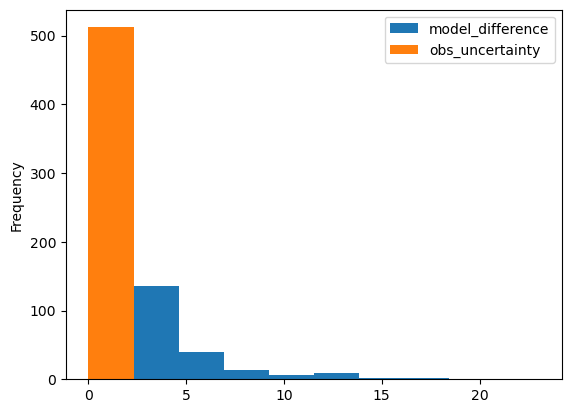

In [102]:
df_out.plot.hist()

In [93]:
df_out.model_difference.values

array([9.19680339e+00, 4.74416422e+00, 2.09672319e-01, 3.04311636e+00,
       3.00609640e+00, 6.00014861e+00, 8.81256620e+00, 5.19971920e+00,
       2.12360387e+00, 1.22916607e+00, 1.98112906e+00, 2.09418163e+00,
       2.38986372e+00, 3.09410189e+00, 9.07389173e-01, 2.24903428e+00,
       8.32804634e+00, 3.67927006e+00, 3.23027592e-01, 1.74535253e+00,
       2.18730378e+00, 1.30282554e+00, 2.02395007e+00, 1.93742177e+00,
       1.84970841e+00, 1.79444790e+00, 3.40555073e+00, 1.80589422e+00,
       1.19381130e+00, 1.94803049e+00, 1.64363824e+00, 2.16583969e+00,
       1.62180550e+00, 2.06287129e-01, 9.26204431e-01, 6.35750466e-01,
       1.49646185e+00, 7.55990556e-02, 8.44452375e-01, 5.37869037e+00,
       2.69710354e+00, 2.74984767e+00, 1.02453746e+00, 2.55249385e+00,
       7.95155475e-01, 5.15888447e+00, 5.95862542e+00, 7.84767115e-01,
       8.82362799e-01, 1.56307245e+00, 1.36756694e+00, 1.46905622e+00,
       3.25385921e+00, 1.20073044e+01, 1.83400222e+00, 9.89952570e-01,
      

In [40]:
df_wflow.index

Index(['2008-10-02', '2008-10-03', '2008-10-04', '2008-10-05', '2008-10-06',
       '2008-10-07', '2008-10-08', '2008-10-09', '2008-10-10', '2008-10-11',
       ...
       '2015-09-21', '2015-09-22', '2015-09-23', '2015-09-24', '2015-09-25',
       '2015-09-26', '2015-09-27', '2015-09-28', '2015-09-29', '2015-09-30'],
      dtype='object', name='time', length=2555)

In [43]:
f"{ROOT}/results/pcr-globwb/evaluation/{basin_id}_evaluation_simulations_adjusted_location_4px.csv"

'/gpfs/work1/0/wtrcycle/users/jaerts/camels_uk/results/pcr-globwb/evaluation/41013_evaluation_simulations_adjusted_location_4px.csv'

In [35]:
df_joined.drop_duplicates()

precipitation   pet  temperature  discharge_spec  discharge_vol  \
2008-10-01           0.14  2.13        12.92            0.12           0.02   
2008-10-02           0.14  1.45         9.14            0.12           0.02   
2008-10-02           0.14  1.45         9.14            0.12           0.02   
2008-10-03           0.00  1.27         7.92            0.12           0.02   
2008-10-03           0.00  1.27         7.92            0.12           0.02   
...                   ...   ...          ...             ...            ...   
2015-09-28           0.00  1.89        13.31            0.18           0.03   
2015-09-29           0.00  2.04        13.54            0.16           0.03   
2015-09-29           0.00  2.04        13.54            0.16           0.03   
2015-09-30           0.00  2.17        13.36            0.16           0.03   
2015-09-30           0.00  2.17        13.36            0.16           0.03   

            peti  humidity  shortwave_rad  longwave_rad  windspeed     wflow  \
2008-10-01  2.38      6.62         139.78        308.46       6.58       NaN   
2008-10-02  1.64      5.16         131.77        291.39       3.80  0.030099   
2008-10-02  1.64      5.16         131.77        291.39       3.80  0.030099   
2008-10-03  1.27      4.93         104.10        299.80       4.48  0.029835   
2008-10-03  1.27      4.93         104.10        299.80       4.48  0.029835   
...          ...       ...            ...           ...        ...       ...   
2015-09-28  1.89      7.36         178.31        299.82       4.41  0.065347   
2015-09-29  2.04      7.26         181.33        297.61       4.86  0.061491   
2015-09-29  2.04      7.26         181.33        297.61       4.86  0.061491   
2015-09-30  2.17      6.90         178.76        295.15       5.32  0.058685   
2015-09-30  2.17      6.90         178.76        295.15       5.32  0.058685   

             pcrglob  model_diff  
2008-10-01       NaN         NaN  
2008-10-02  0.080139    0.050040  
2008-10-02  0.154711    0.124612  
2008-10-03  0.080116    0.050281  
2008-10-03  0.154664    0.124829  
...              ...         ...  
2015-09-28  0.113426    0.048079  
2015-09-29  0.078056    0.016564  
2015-09-29  0.118275    0.056784  
2015-09-30  0.080139    0.021453  
2015-09-30  0.122535    0.063849  

[1911 rows x 13 columns]

In [22]:
df_joined

precipitation   pet  temperature  discharge_spec  discharge_vol  \
2009-01-05           0.00  0.01        -4.38            1.37           3.63   
2009-01-05           0.00  0.01        -4.38            1.37           3.63   
2009-01-05           0.00  0.01        -4.38            1.37           3.63   
2009-01-05           0.00  0.01        -4.38            1.37           3.63   
2009-02-07           0.80  0.30        -2.82            1.37           3.63   
...                   ...   ...          ...             ...            ...   
2015-09-29           0.00  0.97         9.39            0.84           2.24   
2015-09-30           0.06  0.61         6.36            0.81           2.15   
2015-09-30           0.06  0.61         6.36            0.81           2.15   
2015-09-30           0.06  0.61         6.36            0.81           2.15   
2015-09-30           0.06  0.61         6.36            0.81           2.15   

            peti  humidity  shortwave_rad  longwave_rad  windspeed     wflow  \
2009-01-05  0.01      2.56          25.30        228.74       2.00  5.972613   
2009-01-05  0.01      2.56          25.30        228.74       2.00  5.972613   
2009-01-05  0.01      2.56          25.30        228.74       2.00  5.972613   
2009-01-05  0.01      2.56          25.30        228.74       2.00  5.972613   
2009-02-07  0.46      2.66          40.41        254.06       4.84  4.855085   
...          ...       ...            ...           ...        ...       ...   
2015-09-29  0.97      5.93         126.83        280.66       2.70  2.641380   
2015-09-30  0.65      5.41         121.95        270.70       1.38  2.617808   
2015-09-30  0.65      5.41         121.95        270.70       1.38  2.617808   
2015-09-30  0.65      5.41         121.95        270.70       1.38  2.617808   
2015-09-30  0.65      5.41         121.95        270.70       1.38  2.617808   

             pcrglob  model_diff  
2009-01-05  9.286284    3.313671  
2009-01-05  0.000000    5.972613  
2009-01-05  0.000000    5.972613  
2009-01-05  9.286284    3.313671  
2009-02-07  9.917916    5.062831  
...              ...         ...  
2015-09-29  6.677975    4.036595  
2015-09-30  6.620625    4.002817  
2015-09-30  0.000000    2.617808  
2015-09-30  0.000000    2.617808  
2015-09-30  6.620625    4.002817  

[2056 rows x 13 columns]

In [19]:
df_obs_uncertainty = df_obs_selected * (1/uncertainy_average)
df_obs_uncertainty 

precipitation       pet  temperature  discharge_spec  \
date                                                               
2009-01-05       0.000000  0.000743    -0.325348        0.101764   
2009-02-07       0.059424  0.022284    -0.209471        0.101764   
2009-02-11       0.114392  0.009656    -0.293408        0.101764   
2009-02-12       0.268895  0.007428    -0.170845        0.095079   
2009-02-13       0.412256  0.003714    -0.175302        0.092851   
...                   ...       ...          ...             ...   
2015-09-26       0.006685  0.025255     0.667781        0.082451   
2015-09-27       0.000000  0.060167     0.590529        0.071309   
2015-09-28       0.000000  0.057196     0.589786        0.066110   
2015-09-29       0.000000  0.072052     0.697493        0.062396   
2015-09-30       0.004457  0.045311     0.472423        0.060167   

            discharge_vol      peti  humidity  shortwave_rad  longwave_rad  \
date                                                                         
2009-01-05       0.269638  0.000743  0.190158       1.879294     16.990901   
2009-02-07       0.269638  0.034169  0.197586       3.001671     18.871681   
2009-02-11       0.270381  0.012628  0.178273       4.321634     17.047354   
2009-02-12       0.252553  0.010399  0.233983       2.096936     20.756917   
2009-02-13       0.245868  0.004457  0.231012       3.144290     19.631569   
...                   ...       ...       ...            ...           ...   
2015-09-26       0.219870  0.029712  0.465738       1.967688     25.116435   
2015-09-27       0.190158  0.060167  0.421170       7.884865     21.902321   
2015-09-28       0.176045  0.057196  0.424141       5.598514     23.397586   
2015-09-29       0.166388  0.072052  0.440483       9.420984     20.847539   
2015-09-30       0.159703  0.048282  0.401857       9.058496     20.107707   

            windspeed  
date                   
2009-01-05   0.148561  
2009-02-07   0.359517  
2009-02-11   0.161188  
2009-02-12   0.199814  
2009-02-13   0.102507  
...               ...  
2015-09-26   0.149304  
2015-09-27   0.167874  
2015-09-28   0.195357  
2015-09-29   0.200557  
2015-09-30   0.102507  

[514 rows x 10 columns]

In [21]:
df_joined.groupby(by=df_joined.index)